In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [334]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})

df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')

df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)
print(df.columns)

(113472, 4)
Index(['Power', 'POA', 'Tmod', 'Temp'], dtype='object')


In [335]:
# Define the morning hour range
start_hour = 6
end_hour = 21
# Filter rows based on morning hour range
df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
print(df.shape)

(70920, 4)


In [336]:
#df = df[df['POA']>0]
#df = df[df['Power']>0]
#print(df.shape)

In [337]:
# Solar panel = JKM345M-72-V x 5742 panels
POA_std = 1000
Capacity = 5742*345/1000000
T_std = 25 
#T_std = df['Tmod'].mean()
alpha = -0.004

'''
start_date = '2023-11-20'
end_date = '2023-11-22'

test = (df['Power'][start_date:end_date])/(Capacity*(1 + alpha*(df['Tmod'][start_date:end_date] - T_std))*df['POA'][start_date:end_date]/POA_std)
print(test)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
temp = test.dropna()
P_constant = np.mean(temp[temp>0])
P_constant = np.mean(temp)
print(P_constant)
'''

df['shifted_Power'] = df['Power'] 
df.loc['2023-04-02':'2023-09-30', 'shifted_Power'] = df.loc['2023-04-02':'2023-09-30', 'Power'].shift(periods=60, freq='T')


P_constant = 1.0
df['Power_calculated'] = P_constant*Capacity*(1 + alpha*(df['Tmod'] - T_std))*df['POA']/POA_std
#df['Power_error'] = df['Power_calculated'] - df['shifted_Power']

print(df.shape)
df = df[df['Power_calculated']>0]
print(df.shape)

#Performance Ratio (PR) --> PR = (Measured Power / Expected Power)
df['Power_ratio'] = df['shifted_Power']/df['Power_calculated']

#Power Deficit Ratio (PDR) = PDR = ((Expected Power - Measured Power) / Expected Power) Equipment issue
df['Power_deficit_ratio'] = (df['Power_calculated'] - df['shifted_Power'])/df['Power_calculated']



(70920, 6)
(46080, 6)


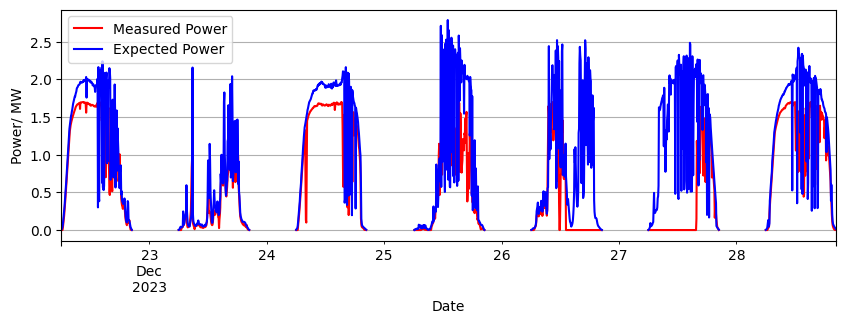

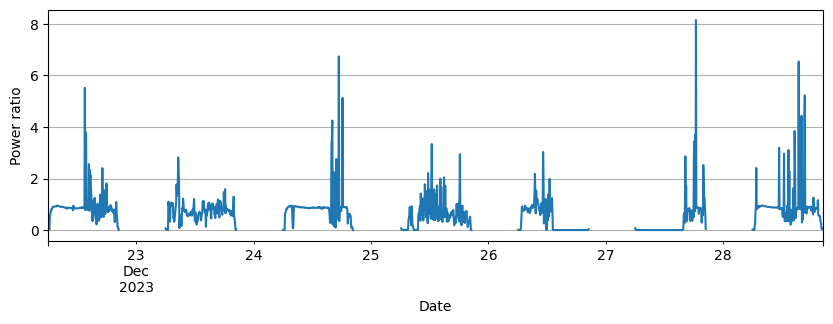

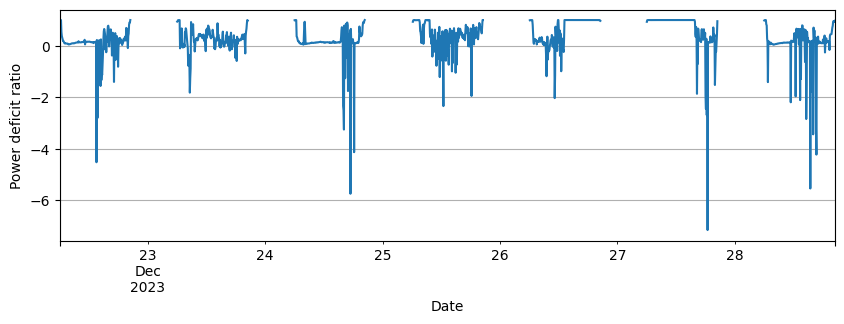

In [338]:
# Define the period you want to plot
start_date = '2023-12-22'
end_date = '2023-12-28'

#start_date = df.index.min()
#end_date = df.index.max()


# Slice the DataFrame based on the specified period
df['shifted_Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Measured Power')
df['Power_calculated'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'],label='Expected Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


ax = df['Power_ratio'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3))
plt.ylabel('Power ratio')
plt.xlabel('Date')
plt.grid(True)
plt.show()

ax = df['Power_deficit_ratio'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3))
plt.ylabel('Power deficit ratio')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [341]:
df.shape

(46080, 8)

In [342]:
df.describe()

Power           POA          Tmod          Temp  shifted_Power  \
count  46080.000000  46080.000000  46080.000000  46080.000000   45783.000000   
mean       0.519451    541.641931     31.279810     22.244951       0.524139   
std        0.572618    392.227931     14.469995     39.329991       0.571164   
min        0.000000      0.488424     -6.118014      0.000000       0.000000   
25%        0.000000    149.721900     20.593310     14.800000       0.000000   
50%        0.260672    568.118300     30.582530     19.500000       0.273010   
75%        1.044369    892.633400     42.587860     25.500000       1.046387   
max        1.700452   1502.591000     68.853870    655.260000       1.700452   

       Power_calculated   Power_ratio  Power_deficit_ratio  
count      46080.000000  45783.000000         45783.000000  
mean           1.011135      0.575009             0.424991  
std            0.710943      0.935735             0.935735  
min            0.000944      0.000000          -115.760963  
25%            0.299994      0.000000             0.132940  
50%            1.096093      0.674752             0.325248  
75%            1.635269      0.867060             1.000000  
max            2.816438    116.760963             1.000000

In [343]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import random

# Example: Generate synthetic time series data (replace with your own data loading)
random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)


# Define the period you want to plot
start_date = df.index.min()
end_date = df.index.max()

temp = df[['Power_ratio','Power_deficit_ratio','Power']].resample('5min').mean()

print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
print(temp.shape)
temp_cleaned = temp.dropna()
print(temp_cleaned.shape)
data = temp_cleaned.values
print(temp_cleaned.index)


full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='5min')
temp_cleaned_reindexed = temp_cleaned.reindex(full_date_range)

df_ffill = temp_cleaned_reindexed.ffill()

if df_ffill.isnull().values.any():
    df_filled = df_ffill.bfill()
else:
    df_filled = df_ffill

True
False
(94557, 3)
(45783, 3)
DatetimeIndex(['2023-03-16 07:10:00', '2023-03-16 07:15:00',
               '2023-03-16 07:20:00', '2023-03-16 07:25:00',
               '2023-03-16 07:30:00', '2023-03-16 07:35:00',
               '2023-03-16 07:40:00', '2023-03-16 07:45:00',
               '2023-03-16 07:50:00', '2023-03-16 07:55:00',
               ...
               '2024-02-07 14:05:00', '2024-02-07 14:10:00',
               '2024-02-07 14:15:00', '2024-02-07 14:20:00',
               '2024-02-07 14:25:00', '2024-02-07 14:30:00',
               '2024-02-07 14:35:00', '2024-02-07 14:40:00',
               '2024-02-07 14:45:00', '2024-02-07 14:50:00'],
              dtype='datetime64[ns]', name='time', length=45783, freq=None)


In [344]:
# Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

In [345]:
# Create sequences/windows

def create_sequences(data, timesteps, overlap):
    sequences = []
    step_size = timesteps - overlap
    num_sequences = (len(data) - timesteps) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        end = start + timesteps
        if end <= len(data):  # Ensure we don't exceed data length
            sequences.append(data[start:end])
    
    return np.array(sequences)


# Train-test split
#X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Define the split ratio
train_ratio = 1.0
test_ratio = 0.0
num_train_samples = int(train_ratio * len(data_normalized))

# Split the data
train_data = data_normalized[:num_train_samples]
test_data = data_normalized[num_train_samples:]

train_data_date = temp_cleaned.index[:num_train_samples]
test_data_date = temp_cleaned.index[num_train_samples:]


timesteps = 16  # Example sequence leng|th
overlap = 12
train_sequences = create_sequences(train_data, timesteps,overlap)
test_sequences = create_sequences(test_data, timesteps,overlap)

print("Shape of the train sequences array:", train_sequences.shape)
print("Shape of the test sequences array:", test_sequences.shape)

Shape of the train sequences array: (11442, 16, 3)
Shape of the test sequences array: (0,)


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 16, 3)]              0         []                            
                                                                                                  
 encoder_lstm1 (LSTM)        (None, 16, 64)               17408     ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_16 (Ba  (None, 16, 64)               256       ['encoder_lstm1[0][0]']       
 tchNormalization)                                                                                
                                                                                                  
 dropout_16 (Dropout)        (None, 16, 64)               0         ['batch_normalization_16[0][

/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 46s 139ms/step - loss: 67.2417 - val_loss: 23.8869 - lr: 0.0010
Epoch 2/100
144/144 [==============================] - ETA: 0s - loss: 47.5033
Epoch 2: val_loss improved from 23.88691 to 13.32782, saving model to /home/ahilan/gen-research/neoen-site/models/anomaly_detection/VAE_one_year_data_best_model.h5
144/144 [==============================] - 15s 103ms/step - loss: 47.5033 - val_loss: 13.3278 - lr: 0.0010
Epoch 3/100
144/144 [==============================] - ETA: 0s - loss: 41.8689
Epoch 3: val_loss improved from 13.32782 to 8.99752, saving model to /home/ahilan/gen-research/neoen-site/models/anomaly_detection/VAE_one_year_data_best_model.h5
144/144 [==============================] - 15s 103ms/step - loss: 41.8689 - val_loss: 8.9975 - lr: 0.0010
Epoch 4/100
144/144 [==============================] - ETA: 0s - loss: 39.1278
Epoch 4: val_loss improved from 8.99752 to 8.01483, saving model to /home/ahilan/gen-research/neoen-site/models/anom

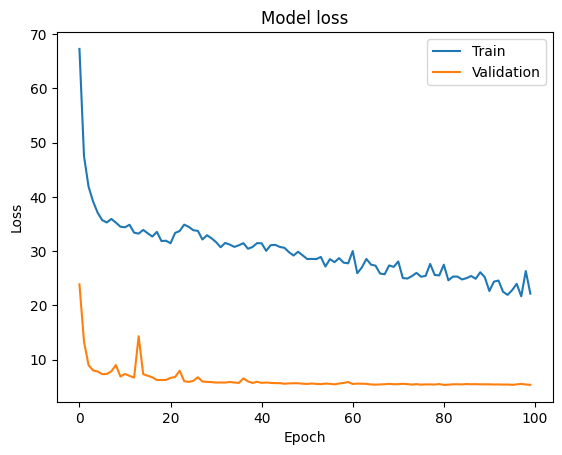

In [202]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 3   
latent_dim = 10
dropout_rate = 0.2

# Encoder
inputs = Input(shape=(timesteps, input_dim),name='encoder_input')
h = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01),name='encoder_lstm1')(inputs)
h = BatchNormalization()(h)
h = Dropout(0.2)(h)
h = LSTM(32, kernel_regularizer=l2(0.01), name='encoder_lstm2')(h)
h = BatchNormalization()(h)
h = Dropout(0.2)(h)
z_mean = Dense(latent_dim,name='z_mean')(h)
z_log_var = Dense(latent_dim,name='z_log_var')(h)
z = Lambda(sampling, output_shape=(latent_dim,),name='z')([z_mean, z_log_var])

# Decoder
#decoder_h1 = Dense(64)
decoder_repeat = RepeatVector(timesteps,name='decoder_repeat')
decoder_h1 = decoder_repeat(z)
decoder_h2 = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01), name='decoder_lstm1')(decoder_h1)
decoder_h2 = BatchNormalization()(decoder_h2)
decoder_h2 = Dropout(0.2)(decoder_h2) 
decoder_h3 = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01),name='decoder_lstm2')(decoder_h2)
decoder_h3 = BatchNormalization()(decoder_h3)
decoder_h3 = Dropout(0.2)(decoder_h3)
decoder_output = TimeDistributed(Dense(input_dim), name='decoder_output')(decoder_h3)
    
# VAE model
vae = Model(inputs, decoder_output, name='vae')
encoder = Model(inputs, z_mean, name='encoder')


# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(decoder_output))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.05*kl_loss)
vae.add_loss(vae_loss)


''''
input_shape = (timesteps, input_dim)

# Define the encoder
encoder_inputs = Input(shape=input_shape, name='encoder_input')
encoder_lstm1 = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='encoder_lstm_1')(encoder_inputs)
encoder_lstm2 = LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, name='encoder_lstm_2')(encoder_lstm1)
encoder_dense1 = Dense(64, activation='relu', name='encoder_dense_1')(encoder_lstm2)
latent_mean = Dense(latent_dim, name='latent_mean')(encoder_dense1)
latent_log_var = Dense(latent_dim, name='latent_log_var')(encoder_dense1)

# Define the latent space
z = Lambda(lambda x: x[0] + K.random_normal(shape=K.shape(x[0])) * K.exp(x[1] / 2), name='latent_sampling')([latent_mean, latent_log_var])

# Define the decoder
decoder_repeated_inputs = RepeatVector(timesteps, name='decoder_repeat_vector')(z)
decoder_lstm1 = LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='decoder_lstm_1')(decoder_repeated_inputs)
decoder_lstm2 = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name='decoder_lstm_2')(decoder_lstm1)
decoder_dense1 = Dense(input_dim, activation='sigmoid', name='decoder_dense_1')(decoder_lstm2)

# Define the VAE model
#vae = Model(inputs=encoder_inputs, outputs=[decoder_dense1, latent_mean, latent_log_var], name='vae')
vae = Model(inputs=encoder_inputs, outputs=[decoder_dense1], name='vae')

# Loss function
reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(decoder_dense1))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + latent_log_var - K.square(latent_mean) - K.exp(latent_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.15*kl_loss)
vae.add_loss(vae_loss)

# Compile model
vae.compile(optimizer='adam')
vae.summary()



# Define the loss function
def vae_loss(y_true, y_pred):
    reconstruction_loss = K.mean(K.square(y_true - y_pred[0]))
    kl_loss = 0.5 * K.mean(1 - K.square(y_pred[1]) - K.exp(y_pred[2]) + y_pred[1])
    return reconstruction_loss + 0.1 * kl_loss

# Define a custom loss function for the VAE model
def vae_custom_loss(y_true, y_pred):
    return vae_loss(y_true, [y_pred[0], y_pred[3], y_pred[4]])

# Compile the VAE model with the custom loss function
vae.compile(optimizer=Adam(lr=0.001), loss=vae_custom_loss)
'''

batch_size = 32
checkpoint_callback = ModelCheckpoint(filepath='/home/ahilan/gen-research/neoen-site/models/anomaly_detection/VAE_one_year_data_best_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                    save_weights_only=False,
                                   verbose=1,
                                   mode='min')

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


# Compile model
vae.compile(optimizer='adam')
vae.summary()


# Train the VAE with early stopping
history = vae.fit(train_sequences, train_sequences, epochs=100, batch_size=64, validation_split=0.2, callbacks=[checkpoint_callback, reduce_lr])


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [325]:
vae = tf.keras.models.load_model('/home/ahilan/gen-research/neoen-site/models/anomaly_detection/VAE_one_year_data_best_model_16_12_K_0.05.h5')

358/358 [==============================] - 7s 13ms/step


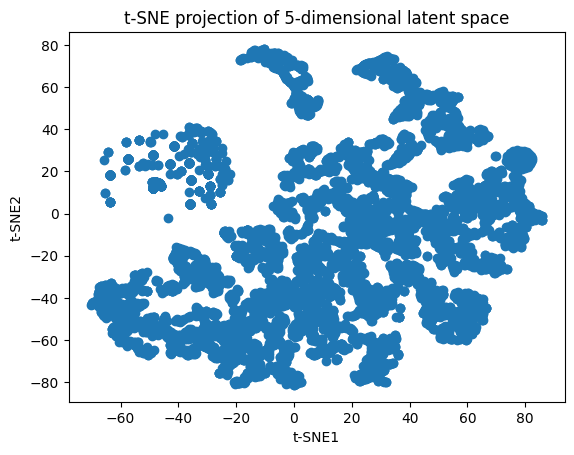

In [326]:
inputs = vae.get_layer('encoder_input').input
z_mean = vae.get_layer('z_mean').output

encoder = Model(inputs, z_mean)
#encoded_data = encoder.predict(train_sequences[:,:,1])
encoded_data = encoder.predict(train_sequences)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE projection of 5-dimensional latent space')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

(11442, 16, 3)
(11442, 10)


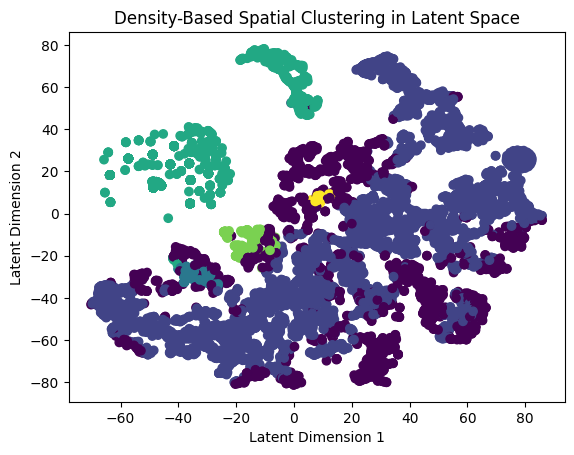

In [327]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters using the Elbow method
#wcss = []
#for i in range(1, 11):
#    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#    kmeans.fit(encoded_data)
#    wcss.append(kmeans.inertia_)

#plt.plot(range(1, 11), wcss)
#plt.title('Elbow Method')
#plt.xlabel('Number of clusters')
#plt.ylabel('WCSS')
#plt.show()

# Fit K-Means with optimal clusters
#np.random.seed(42)
#optimal_clusters = 4  # Example
#kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
#clusters = kmeans.fit_predict(encoded_data)


# Fit DBSCAN
#dbscan = DBSCAN(eps=0.5, min_samples=50)
#clusters = dbscan.fit_predict(encoded_data)

'''
# Define a grid of potential `eps` and `min_samples` values
eps_values = np.linspace(0.05, 0.5, 10)
min_samples_values = range(5, 100, 10)


best_score = -1
best_params = {}

# Iterate over all combinations of `eps` and `min_samples`
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(encoded_data)
        
        # Only compute the score if more than one cluster was found
        if len(set(labels)) > 1:
            score = silhouette_score(encoded_data, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best silhouette score: {best_score}")
print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
'''
print(train_sequences.shape)
print(encoded_data.shape)
dbscan = DBSCAN(eps=0.9, min_samples=45)
clusters = dbscan.fit_predict(encoded_data)


plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Density-Based Spatial Clustering in Latent Space')
plt.show()


#from sklearn.mixture import GaussianMixture
# Fit GMM to the latent space
#gmm = GaussianMixture(n_components=4, random_state=0).fit(encoded_data)

# Assign cluster labels and get probabilities
#clusters = gmm.predict(encoded_data)
#probabilities = gmm.predict_proba(encoded_data)

# Visualize the clusters in the latent space (for 2D or 3D latent space)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.title('GMM Clustering in Latent Space')
#plt.show()

In [328]:
reconstructed_sequences = vae.predict(train_sequences)

358/358 [==============================] - 13s 24ms/step


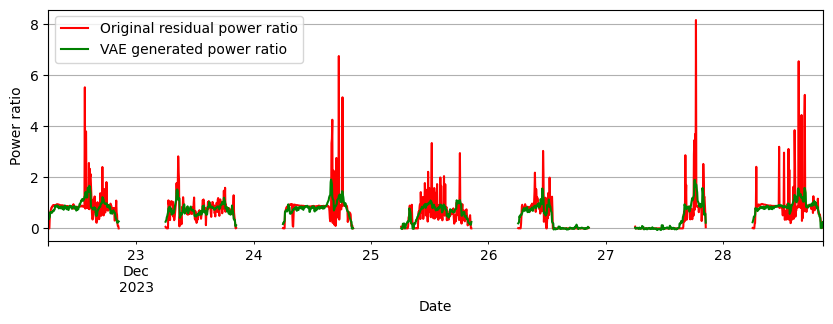

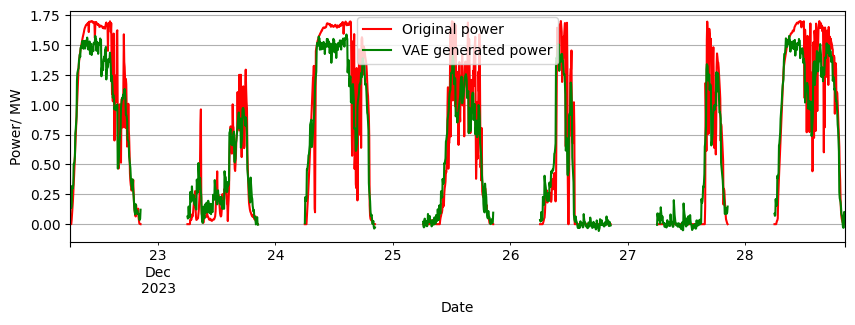

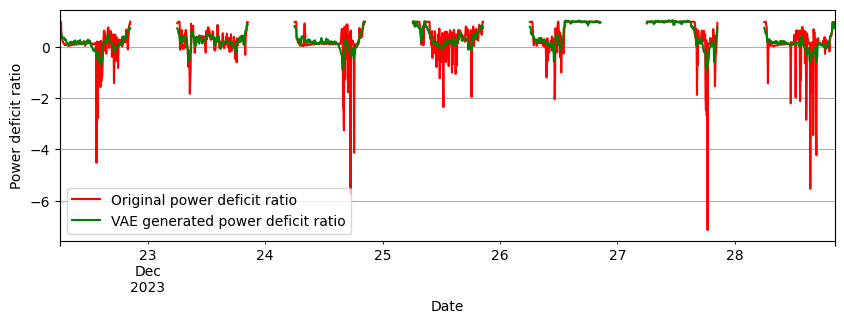

In [351]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# 1. Reshape sequences back to original form
original_shape = (len(data), 3)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)
reconstruction_error = np.zeros(original_shape)


#num_sequences = (len(train_sequences) - timesteps) // timesteps + 1
#print(num_sequences)
step_size = timesteps - overlap
for i in range(len(train_sequences)-timesteps):
    start = i * step_size
    end = start + timesteps
    reconstructed_original_data[start:end] = train_sequences[i]
    reconstructed_vae_data[start:end] = reconstructed_sequences[i]


X_test_original = scaler.inverse_transform(reconstructed_original_data)
X_test_vae = scaler.inverse_transform(reconstructed_vae_data)


df_orginal = pd.DataFrame(data = X_test_original, index = train_data_date, columns = ['Power_ratio','Power_deficit_ratio','Power'])
df_vae_output = pd.DataFrame(data = X_test_vae, index = train_data_date, columns = ['Power_ratio','Power_deficit_ratio','Power'])



#df_orginal['reconstruction_error'] = np.square(df_orginal - df_vae_output)



# Define the period you want to plot
start_date = '2023-12-22'
end_date = '2023-12-28'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]


df_orginal_period['Power_ratio'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original residual power ratio')
df_vae_output_period['Power_ratio'].resample('5min').mean().plot(figsize=(10, 3),color =['Green'],label='VAE generated power ratio')
#plt.scatter(df_orginal_period.index[df_orginal_period['anomaly'] == 1], df_orginal_period['Power_error'][df_orginal_period['anomaly'] == 1], color='black', label='Anomaly')
plt.ylabel('Power ratio')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

df_orginal_period['Power'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power')
df_vae_output_period['Power'].resample('5min').mean().plot(figsize=(10, 3),color =['Green'],label='VAE generated power')
#plt.scatter(df_orginal_period.index[df_orginal_period['anomaly'] == 1], df_orginal_period['Power_error'][df_orginal_period['anomaly'] == 1], color='black', label='Anomaly')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


df_orginal_period['Power_deficit_ratio'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power deficit ratio')
df_vae_output_period['Power_deficit_ratio'].resample('5min').mean().plot(figsize=(10, 3),color =['Green'],label='VAE generated power deficit ratio')
#plt.scatter(df_orginal_period.index[df_orginal_period['anomaly'] == 1], df_orginal_period['Power_error'][df_orginal_period['anomaly'] == 1], color='black', label='Anomaly')
plt.ylabel('Power deficit ratio')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


#plt.scatter(df_orginal_period.index[df_orginal_period['anomaly'] == 1], df_orginal_period['Power_error'][df_orginal_period['anomaly'] == 1], color='black', label='Anomaly')
#plt.ylabel('Power/ MW')
#plt.xlabel('Date')
#plt.legend()
#plt.grid(True)
#plt.show()


In [352]:
array_b = np.zeros((train_sequences.shape[0], train_sequences.shape[1], 1))
reconstructed_sequences_temp = np.concatenate([reconstructed_sequences,array_b], axis=-1) 
reconstructed_sequences_temp[:,:,1] = train_sequences[:,:,1]

# Add cluster labels to the original sequences
clusters_temp = np.repeat(clusters[:, None, None], train_sequences.shape[1], axis=1)
original_sequences_with_clusters = np.concatenate([train_sequences, clusters_temp], axis=-1)
reconstructed_sequences_with_clusters = np.concatenate([reconstructed_sequences_temp, clusters_temp], axis=-1)


# Initialize an array to hold cluster IDs for the entire time series
cluster_ids = np.full(len(train_data), -1)



num_sequences = (len(data) - timesteps) // timesteps + 1
step_size = timesteps - overlap
for i in range(num_sequences):
    start = i * step_size
    end = start + timesteps
    cluster_ids[start:end] = clusters[i]

'''
# Handle the overlapping indices by assigning the most frequent cluster ID
# Create a copy of cluster_ids to update with the most frequent cluster ID
updated_cluster_ids = cluster_ids.copy()
# Handle the overlapping indices by assigning the most frequent cluster ID
for i in range(len(cluster_ids) - timesteps + 1):
    window = cluster_ids[i:i + timesteps]
    unique, counts = np.unique(window[window != -1], return_counts=True)  # Ignore unassigned (-1) values
    if len(unique) > 0:  # Ensure there are assigned values in the window
        most_frequent_cluster = unique[np.argmax(counts)]
        updated_cluster_ids[i:i + timesteps] = most_frequent_cluster
'''

# Ensure the cluster_ids array has the same length as the original time series
cluster_ids = cluster_ids[:len(train_data)]

df_orginal['Clusters'] = cluster_ids



In [353]:
'''
# Preprocessing
power_ratio = df_orginal['Power_error'].values
scaler = MinMaxScaler(feature_range=(0, 1))
power_ratio_scaled = scaler.fit_transform(power_ratio.reshape(-1, 1))


# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(power_ratio_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


# Fit K-Means with optimal clusters
optimal_clusters = 4  # Example
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_orginal['data_clusters'] = kmeans.fit_predict(power_ratio_scaled)

from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan_labels = dbscan.fit_predict(power_ratio_scaled)

# Add DBSCAN labels to data
df_orginal['dbscan_label'] = dbscan_labels

print(df_orginal['dbscan_label'])

# Identify anomalies (label = -1 in DBSCAN)
#anomalies = data[data['dbscan_label'] == -1]
'''

'''
plt.scatter(data['timestamp'], power_ratio, c=data['cluster'], cmap='viridis')
plt.title('Power Ratio Clusters')
plt.xlabel('Time')
plt.ylabel('Power Ratio')
plt.show()


plt.scatter(data['timestamp'], power_ratio, c='blue', label='Normal')
plt.scatter(anomalies['timestamp'], anomalies['power_ratio'], c='red', label='Anomaly')
plt.title('Anomalies in Power Ratio')
plt.xlabel('Time')
plt.ylabel('Power Ratio')
plt.legend()
plt.show()
'''

"\nplt.scatter(data['timestamp'], power_ratio, c=data['cluster'], cmap='viridis')\nplt.title('Power Ratio Clusters')\nplt.xlabel('Time')\nplt.ylabel('Power Ratio')\nplt.show()\n\n\nplt.scatter(data['timestamp'], power_ratio, c='blue', label='Normal')\nplt.scatter(anomalies['timestamp'], anomalies['power_ratio'], c='red', label='Anomaly')\nplt.title('Anomalies in Power Ratio')\nplt.xlabel('Time')\nplt.ylabel('Power Ratio')\nplt.legend()\nplt.show()\n"

2023-03-20 00:00:00
2023-03-24 00:00:00


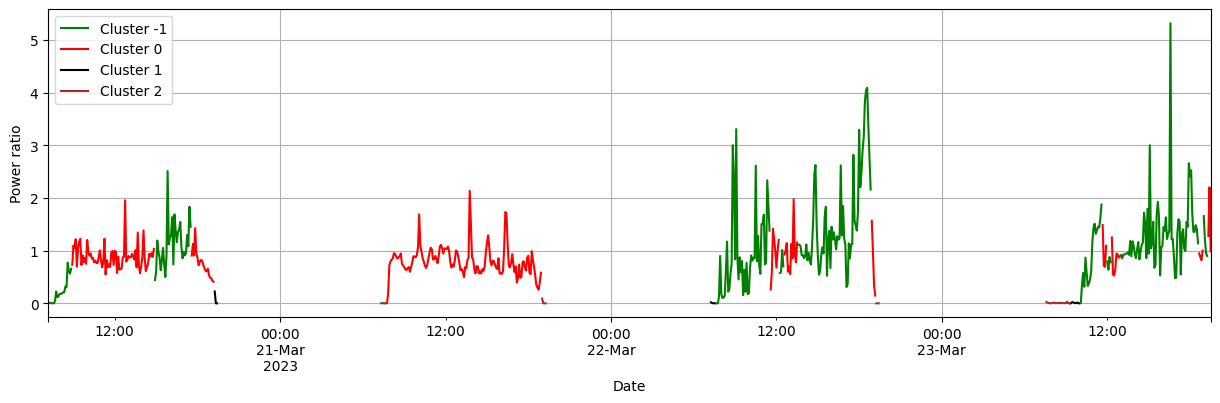

2023-03-23 00:00:00
2023-03-27 00:00:00


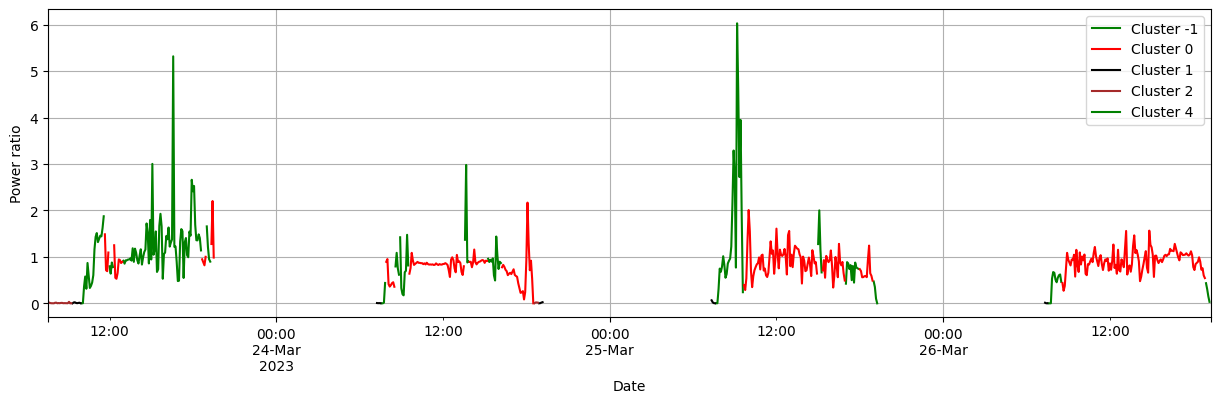

2023-03-26 00:00:00
2023-03-30 00:00:00


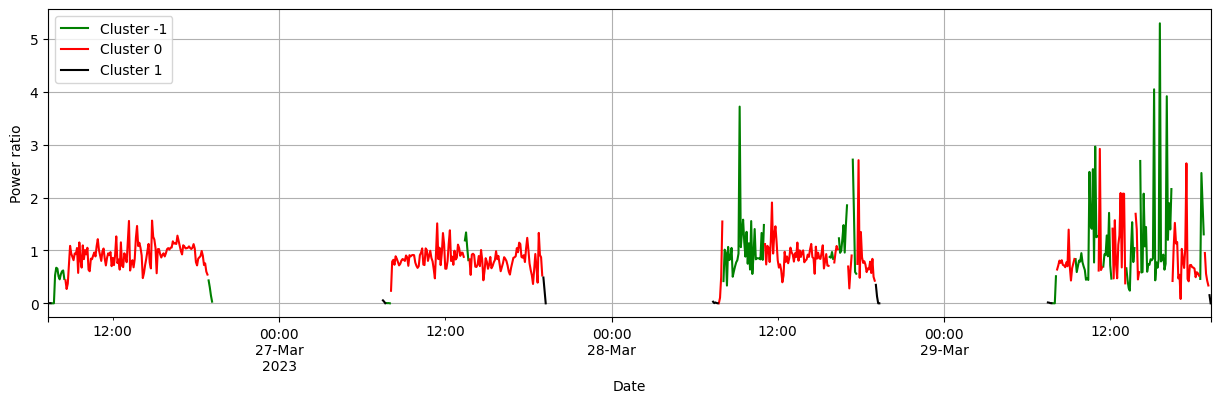

2023-03-29 00:00:00
2023-04-02 00:00:00


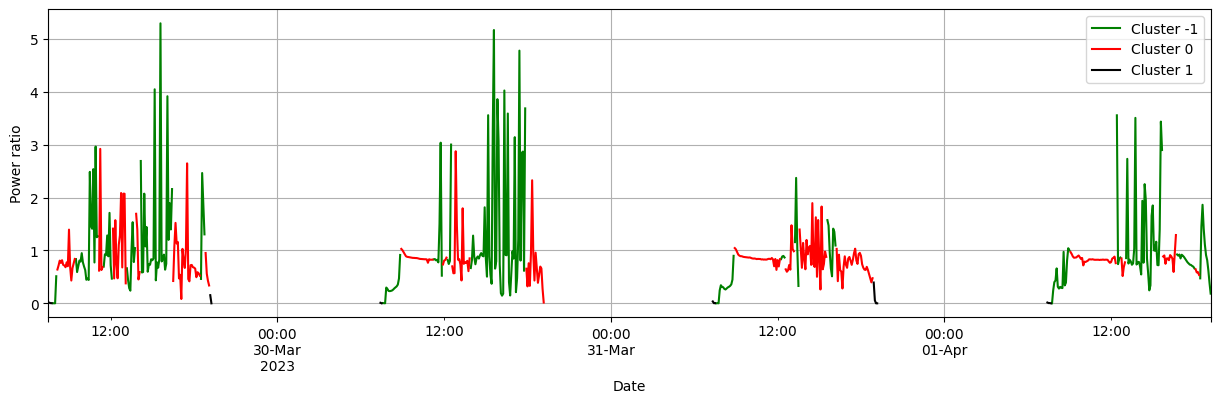

2023-04-01 00:00:00
2023-04-05 00:00:00


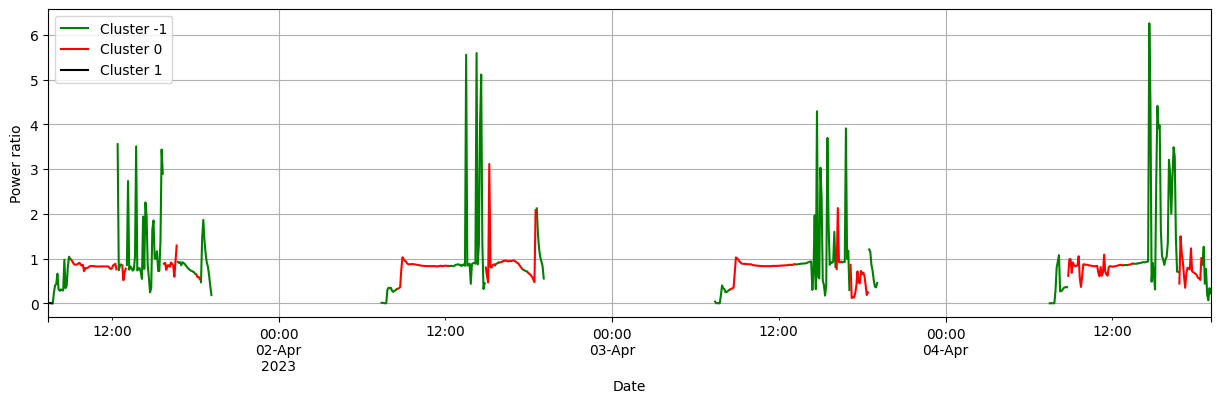

2023-04-04 00:00:00
2023-04-08 00:00:00


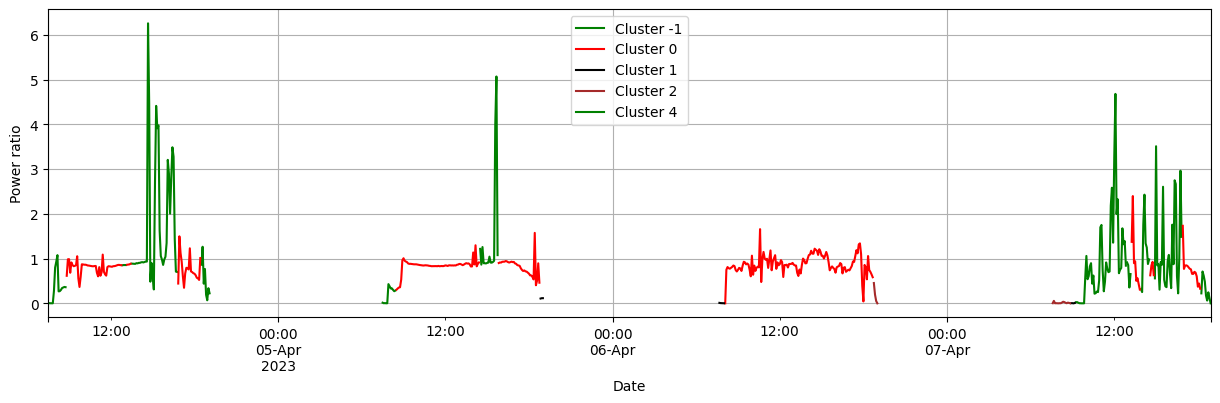

2023-04-07 00:00:00
2023-04-11 00:00:00


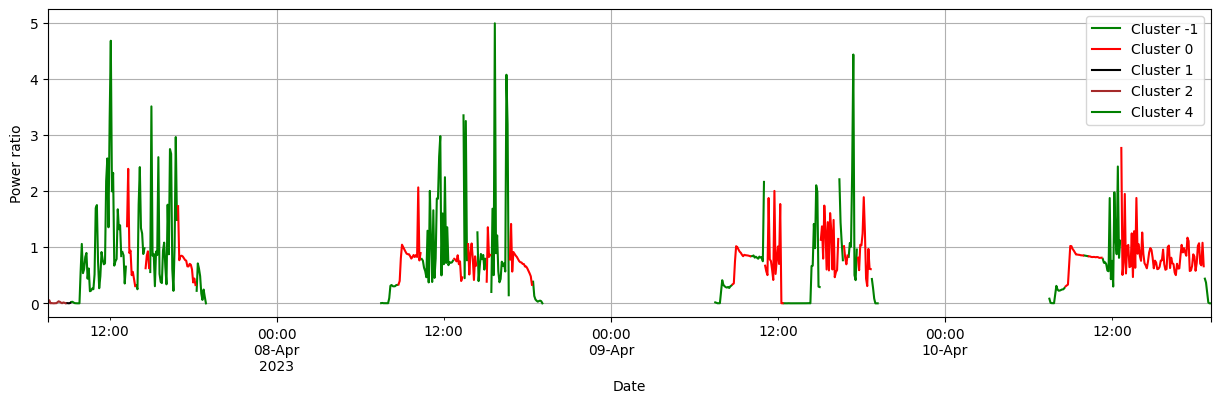

2023-04-10 00:00:00
2023-04-14 00:00:00


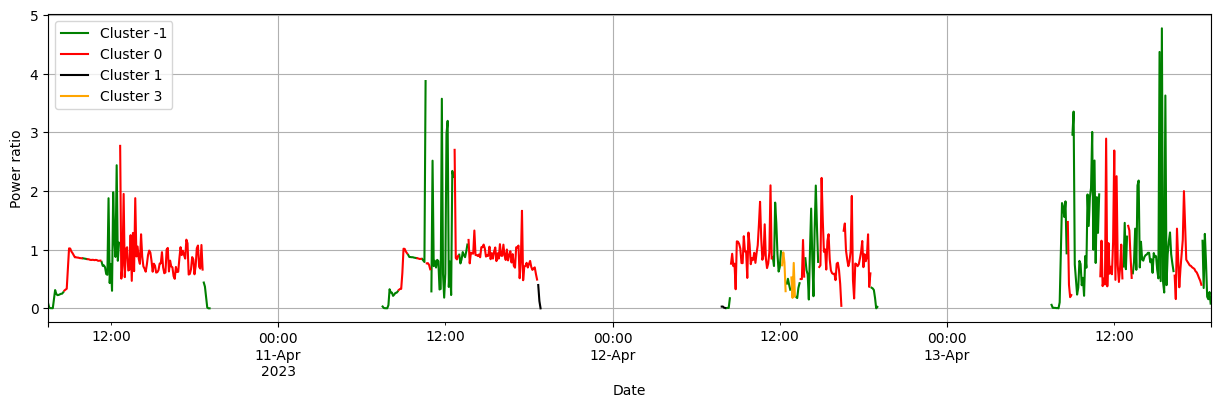

2023-04-13 00:00:00
2023-04-17 00:00:00


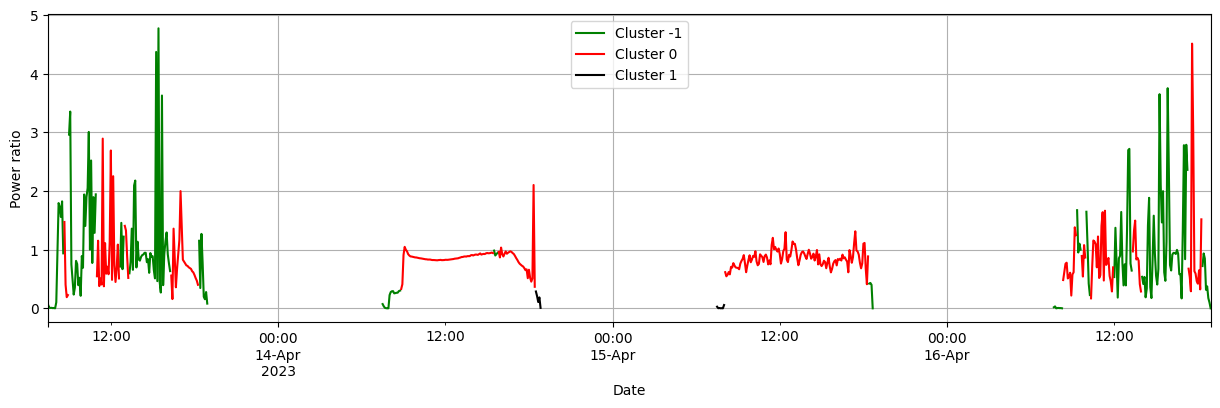

2023-04-16 00:00:00
2023-04-20 00:00:00


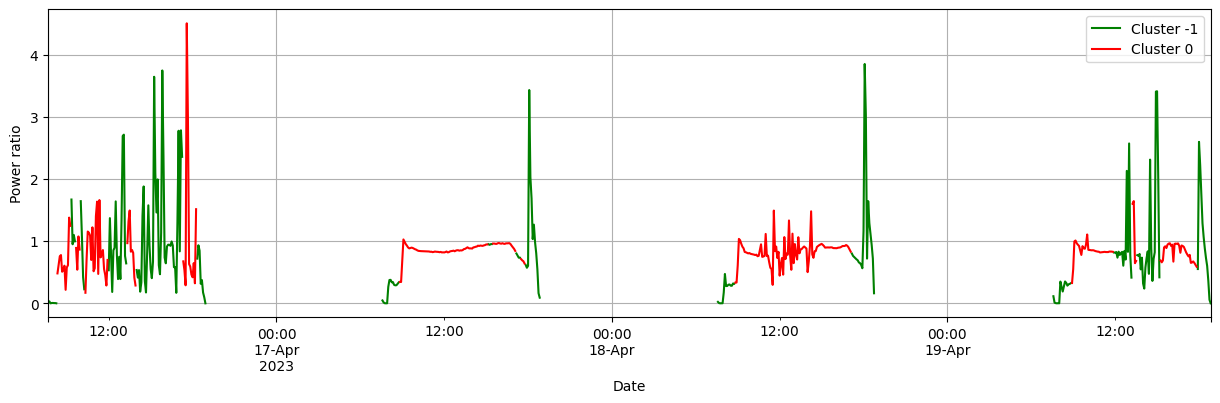

2023-04-19 00:00:00
2023-04-23 00:00:00


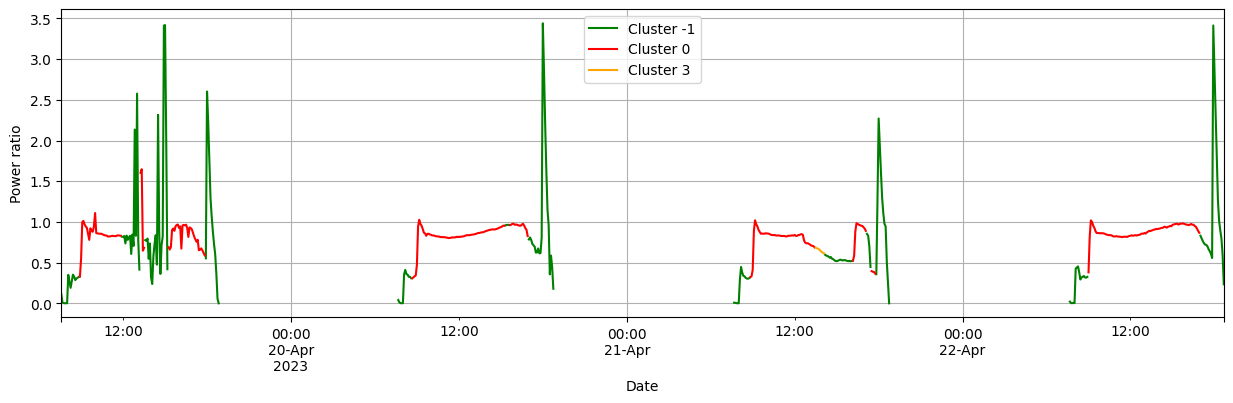

2023-04-22 00:00:00
2023-04-26 00:00:00


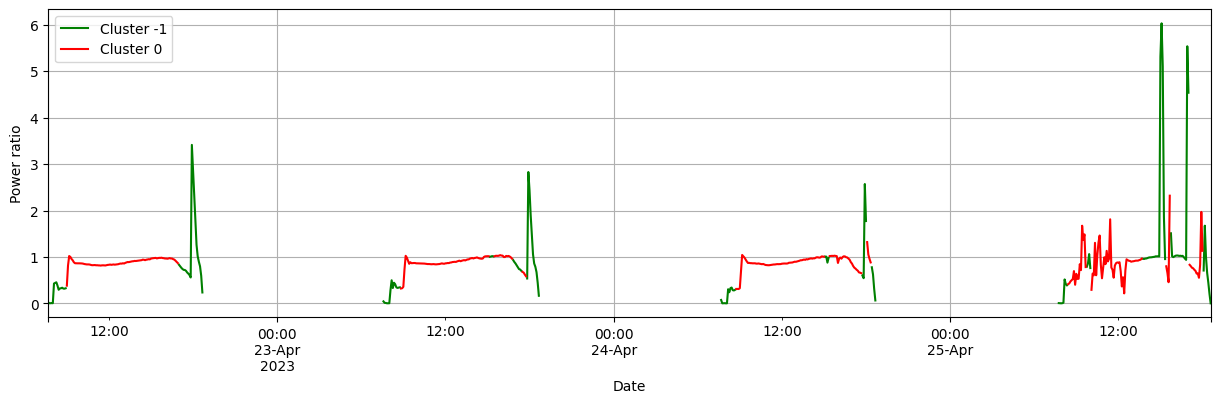

2023-04-25 00:00:00
2023-04-29 00:00:00


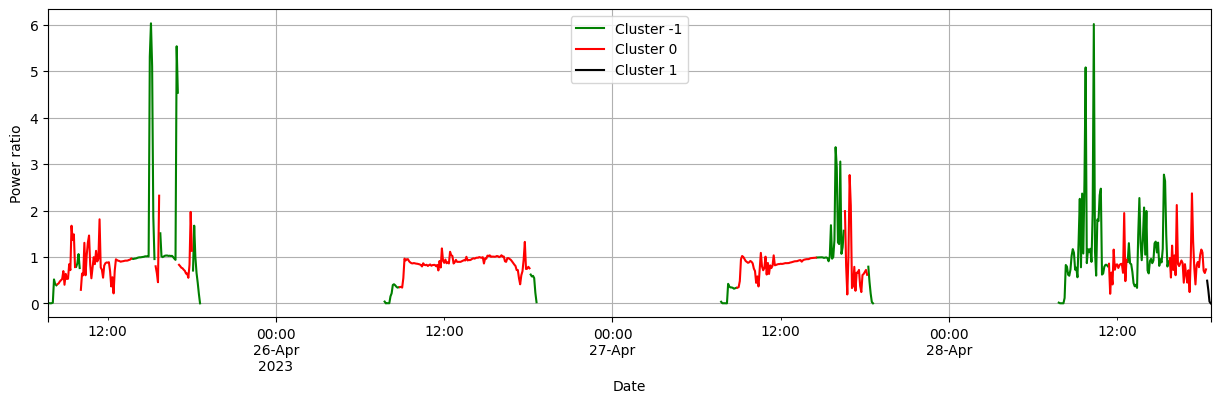

2023-04-28 00:00:00
2023-05-02 00:00:00


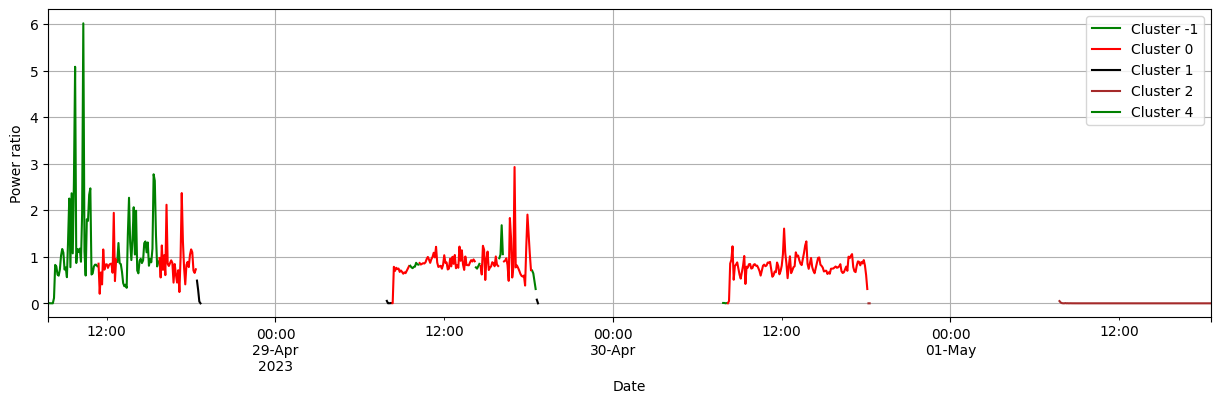

2023-05-01 00:00:00
2023-05-05 00:00:00


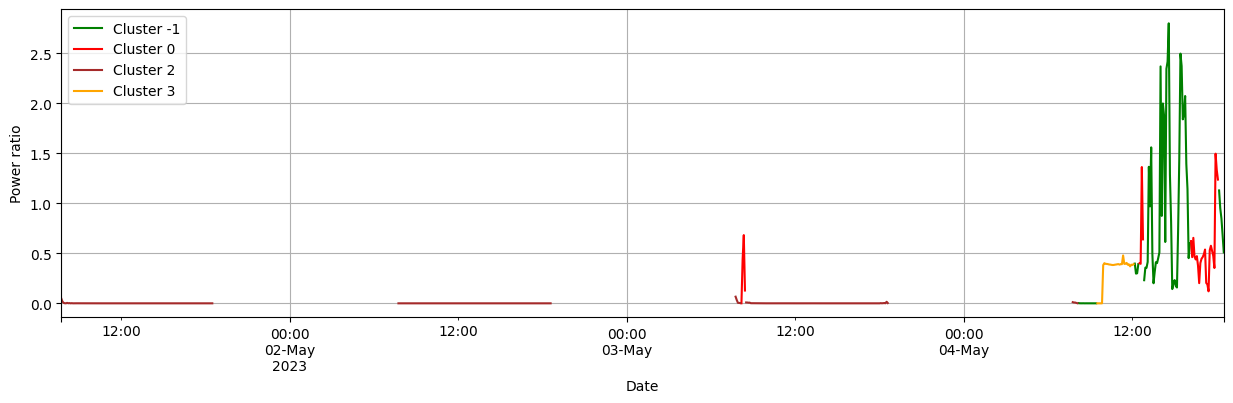

2023-05-04 00:00:00
2023-05-08 00:00:00


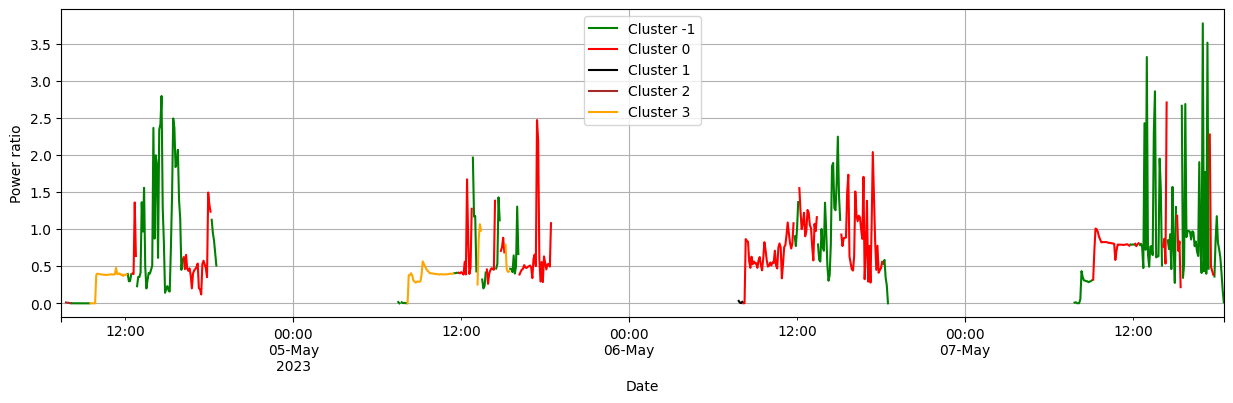

2023-05-07 00:00:00
2023-05-11 00:00:00


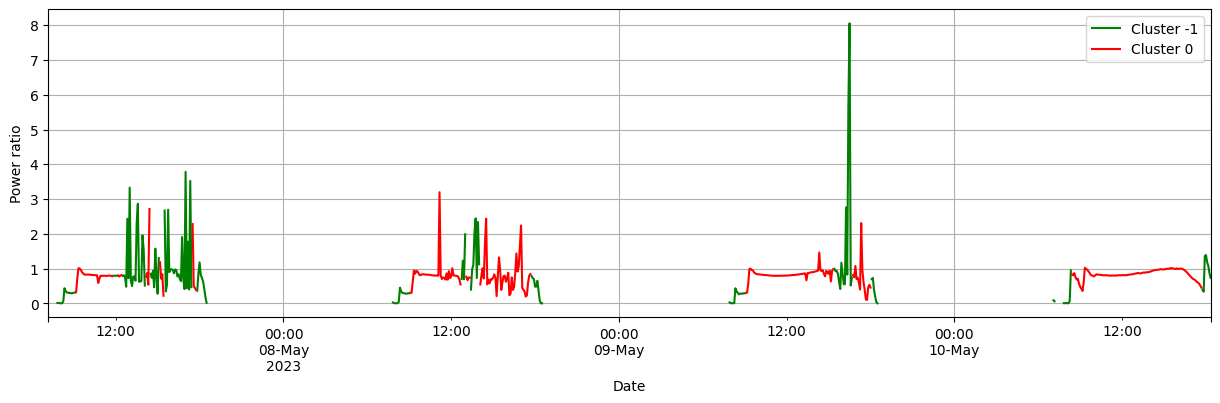

2023-05-10 00:00:00
2023-05-14 00:00:00


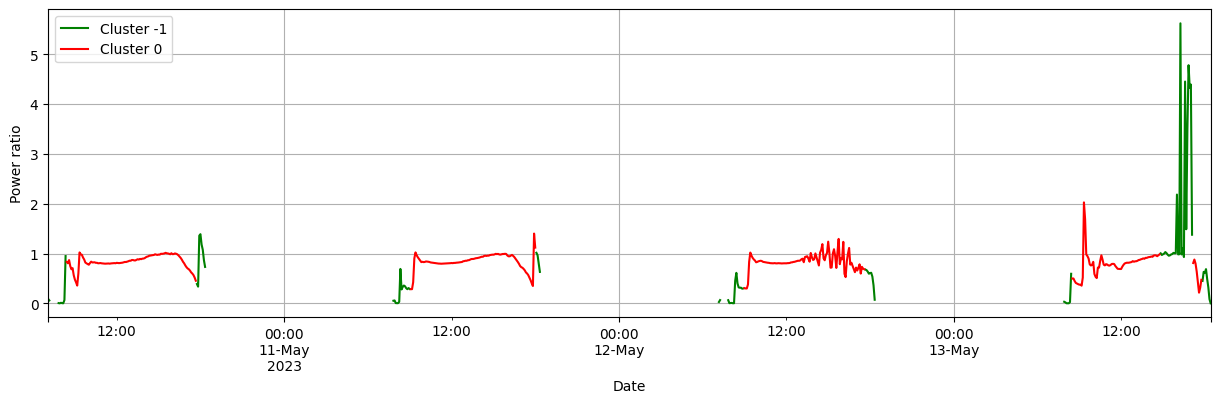

2023-05-13 00:00:00
2023-05-17 00:00:00


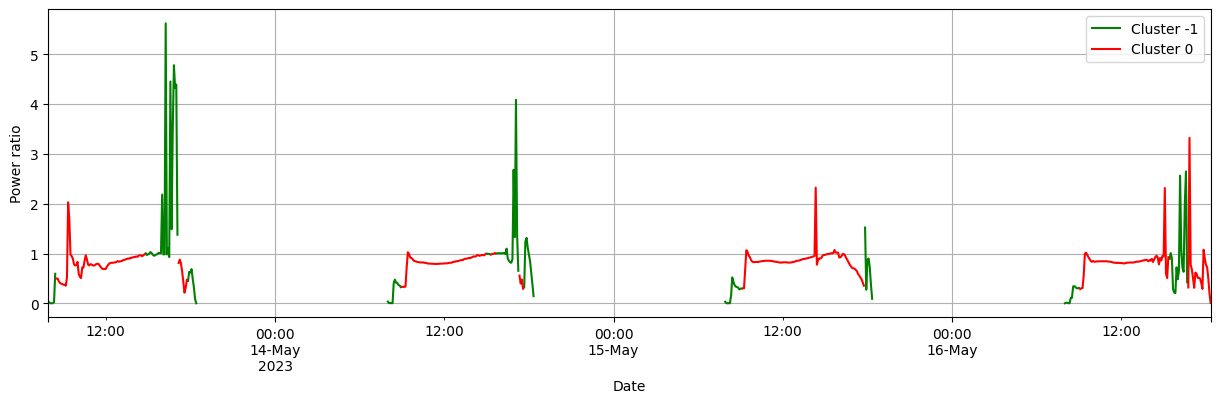

2023-05-16 00:00:00
2023-05-20 00:00:00


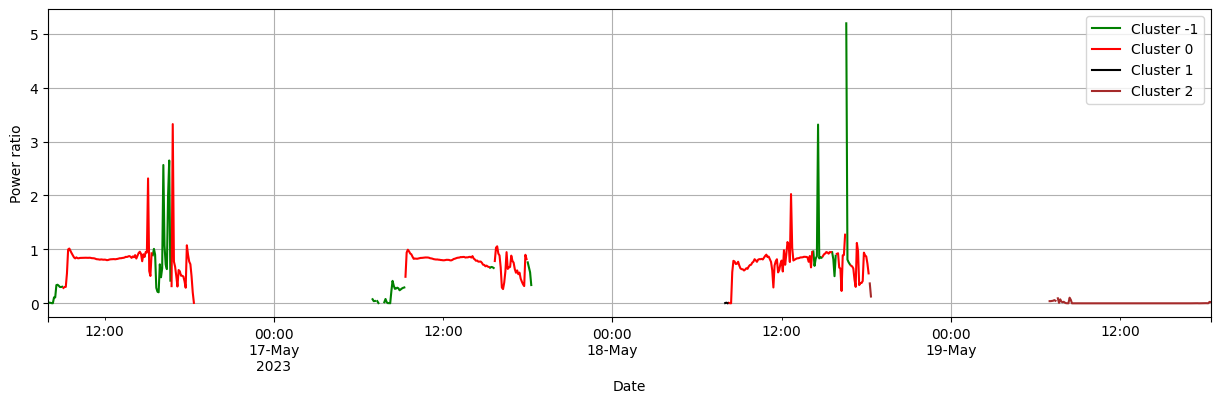

2023-05-19 00:00:00
2023-05-23 00:00:00


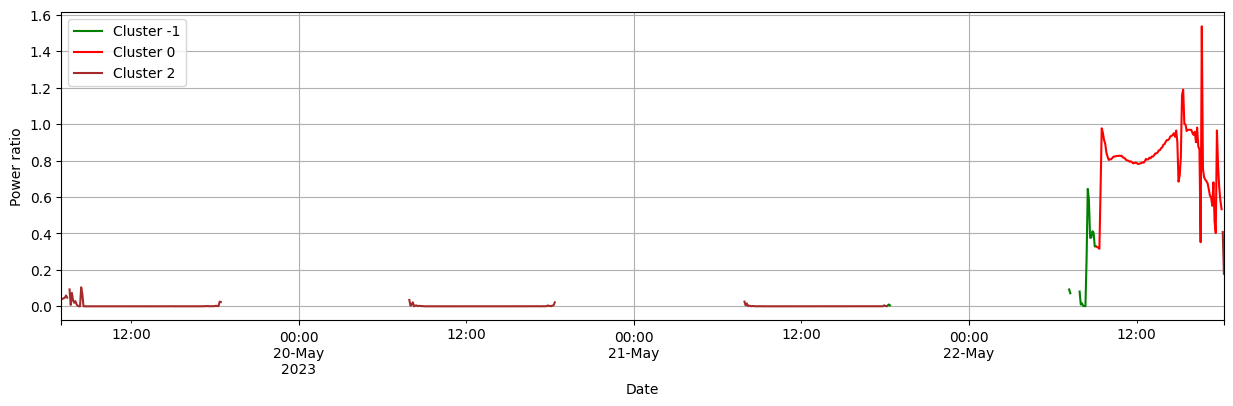

2023-05-22 00:00:00
2023-05-26 00:00:00


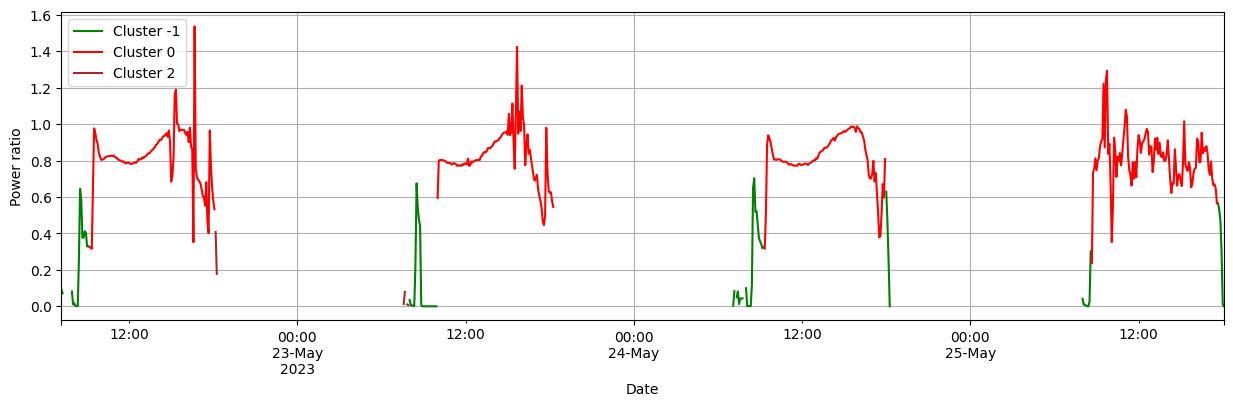

2023-05-25 00:00:00
2023-05-29 00:00:00


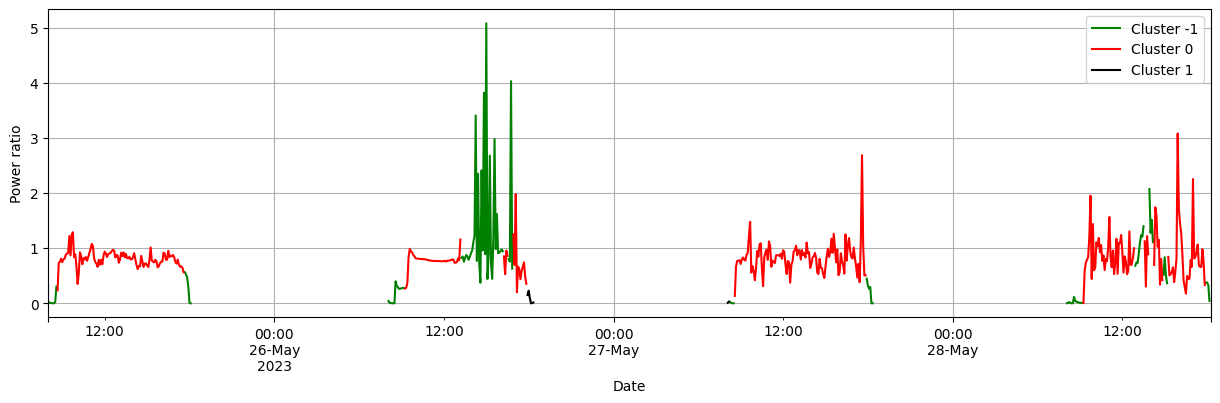

2023-05-28 00:00:00
2023-06-01 00:00:00


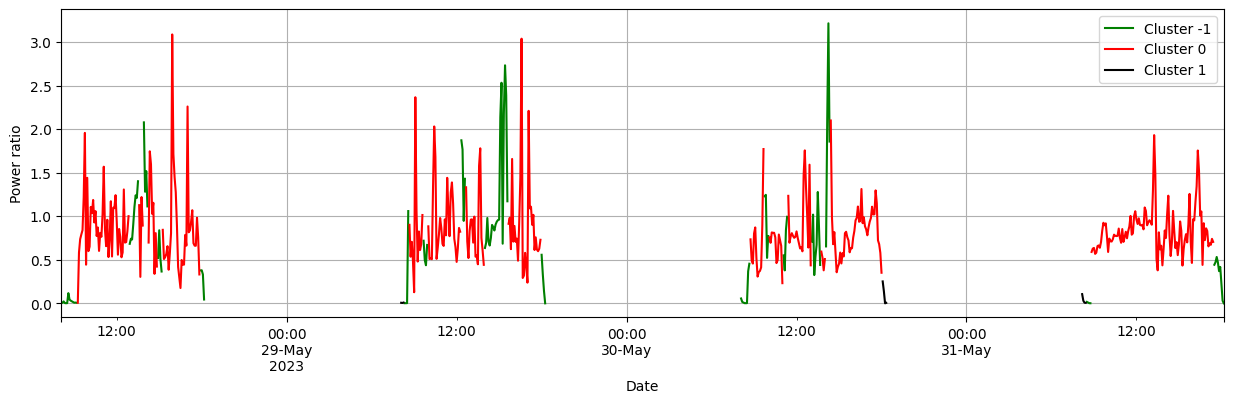

2023-05-31 00:00:00
2023-06-04 00:00:00


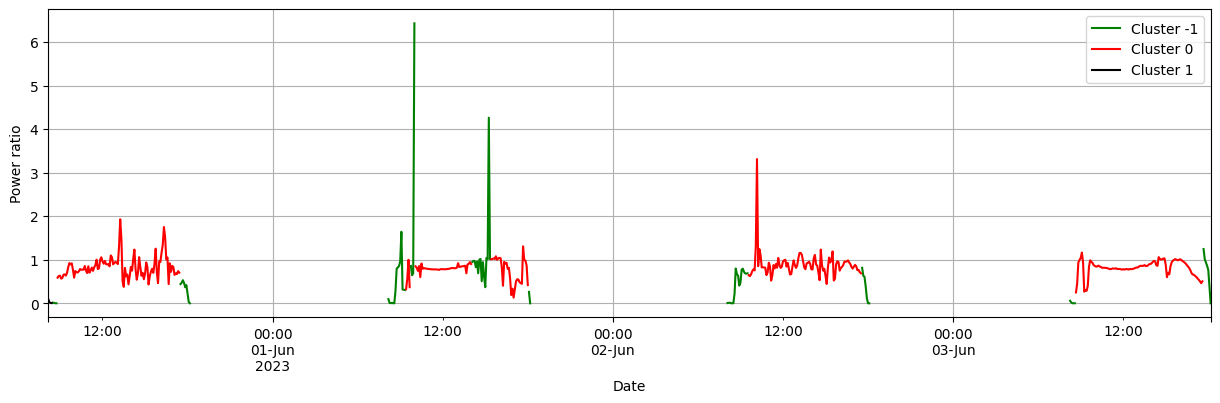

2023-06-03 00:00:00
2023-06-07 00:00:00


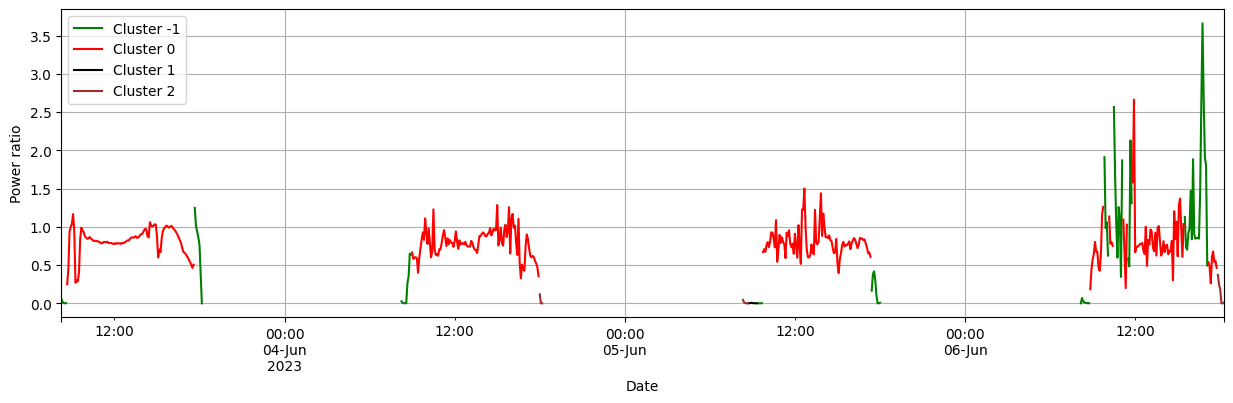

2023-06-06 00:00:00
2023-06-10 00:00:00


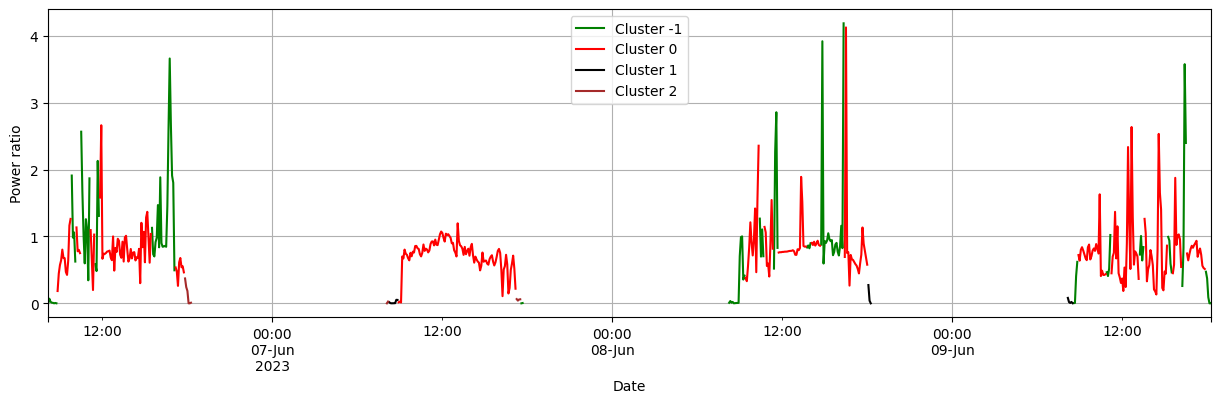

2023-06-09 00:00:00
2023-06-13 00:00:00


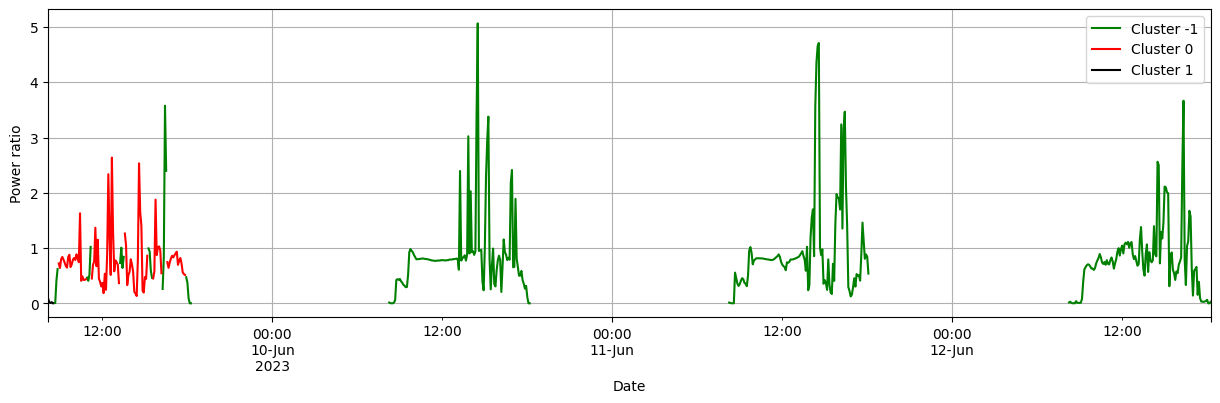

2023-06-12 00:00:00
2023-06-16 00:00:00


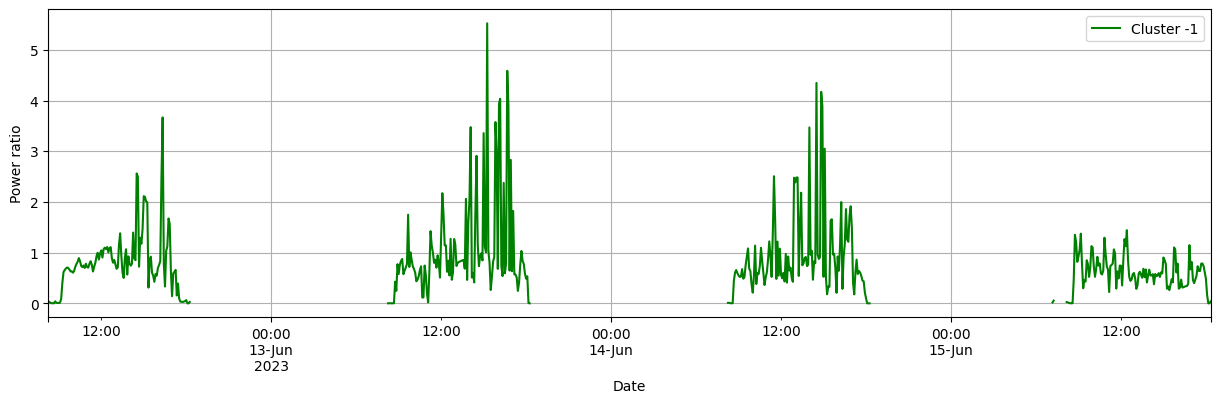

2023-06-15 00:00:00
2023-06-19 00:00:00


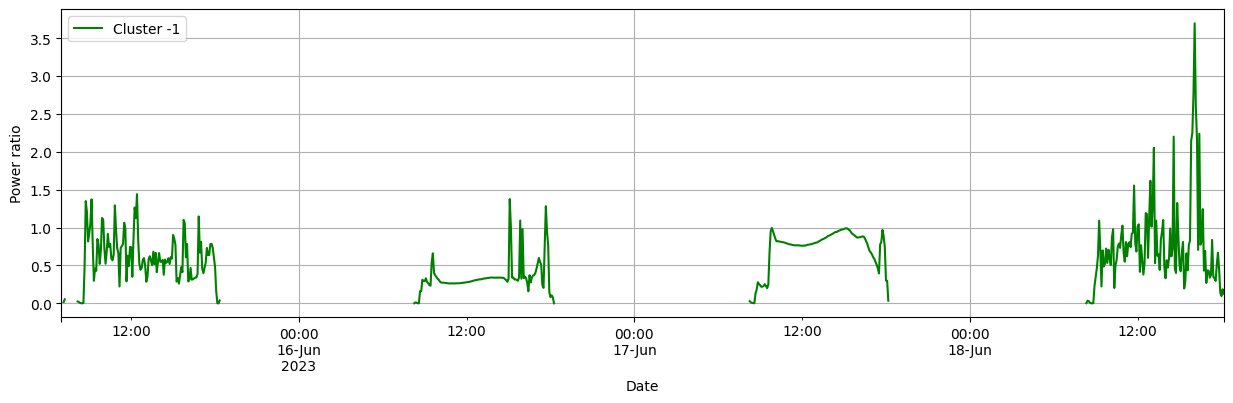

2023-06-18 00:00:00
2023-06-22 00:00:00


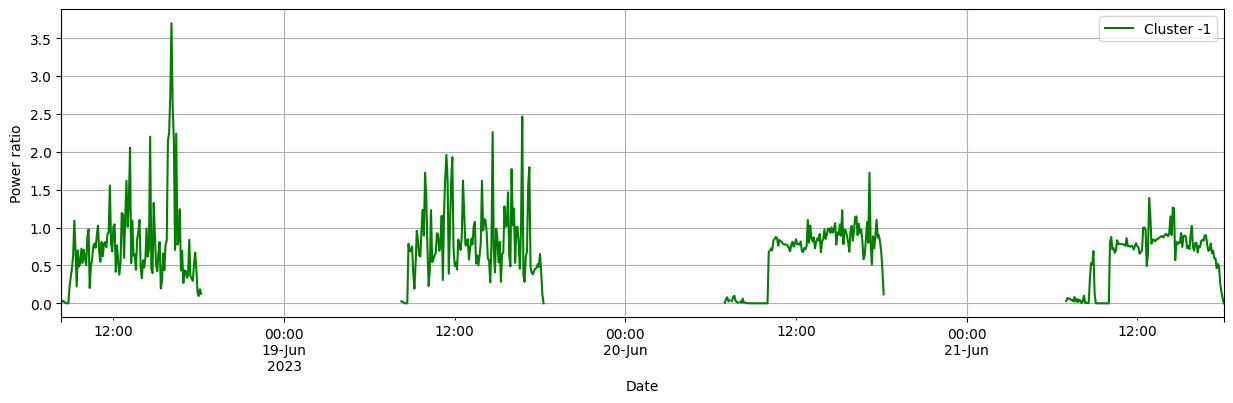

2023-06-21 00:00:00
2023-06-25 00:00:00


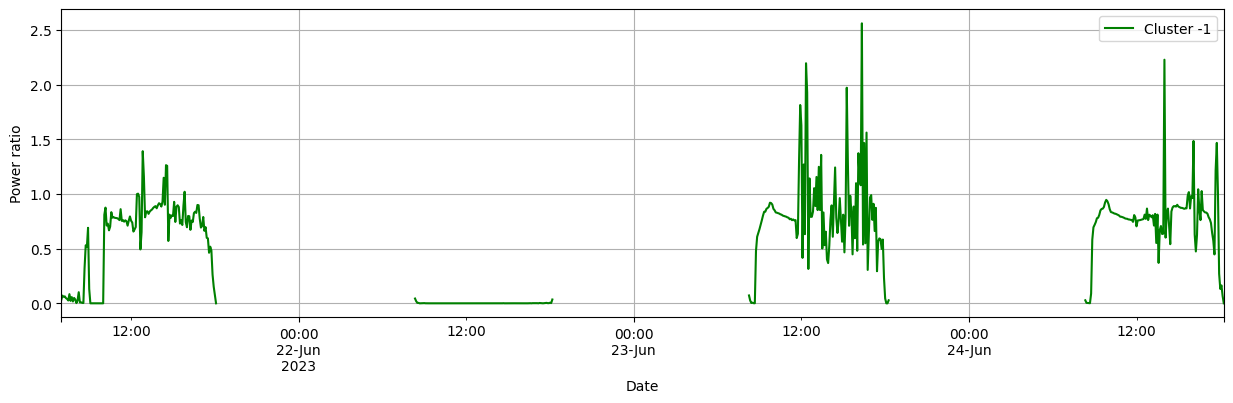

2023-06-24 00:00:00
2023-06-28 00:00:00


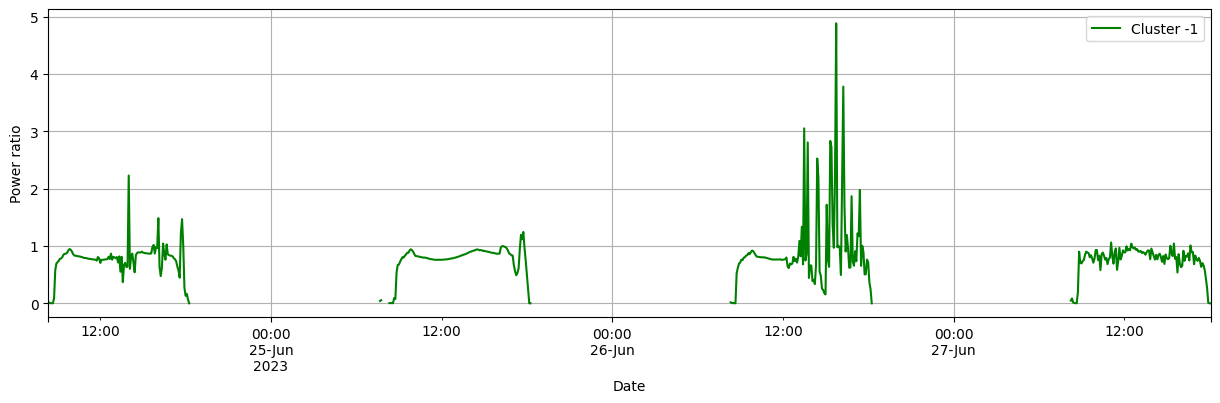

2023-06-27 00:00:00
2023-07-01 00:00:00


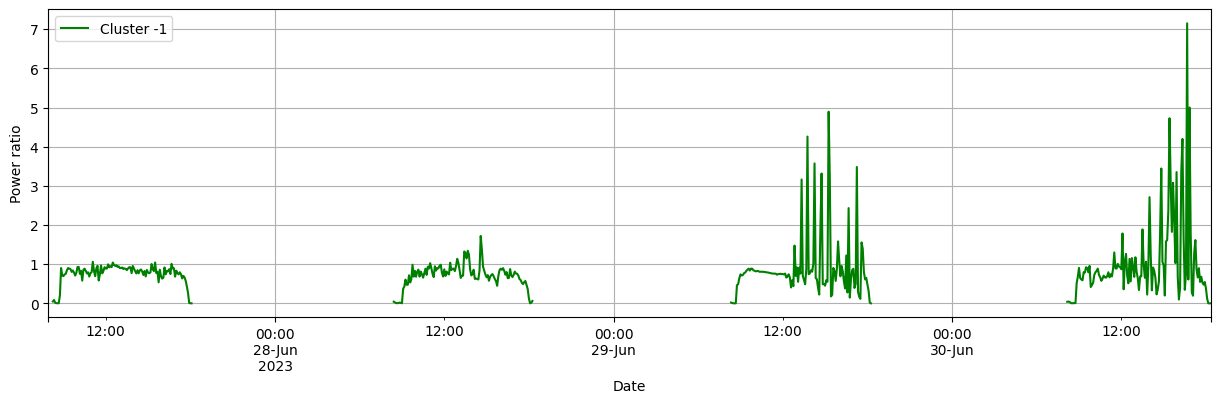

2023-06-30 00:00:00
2023-07-04 00:00:00


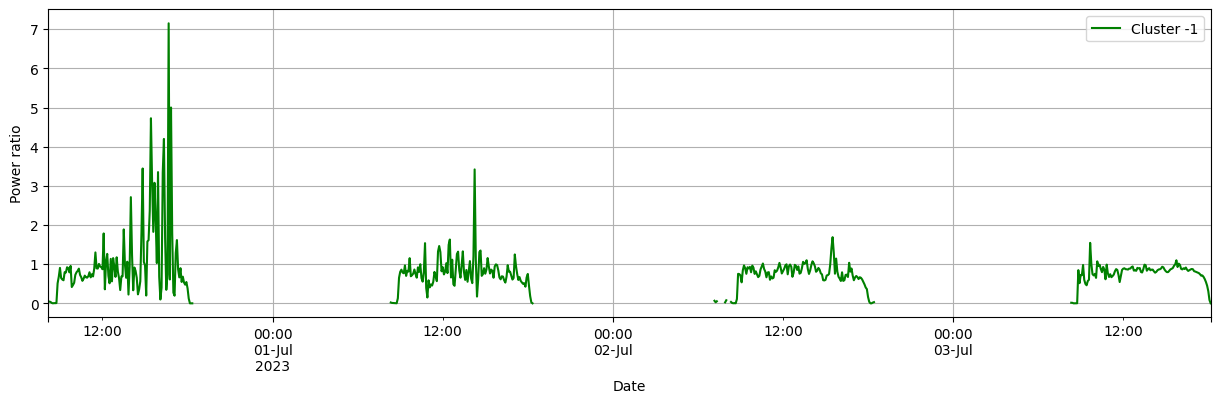

2023-07-03 00:00:00
2023-07-07 00:00:00


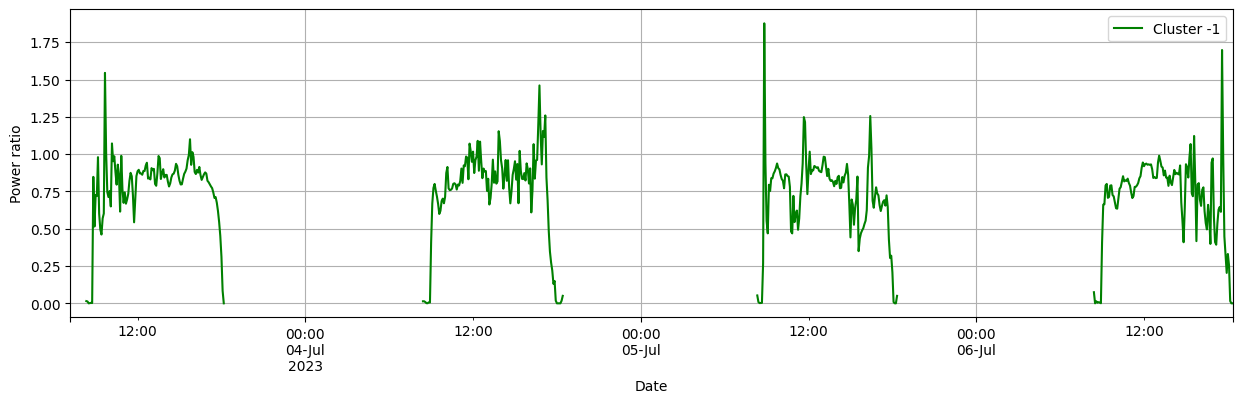

2023-07-06 00:00:00
2023-07-10 00:00:00


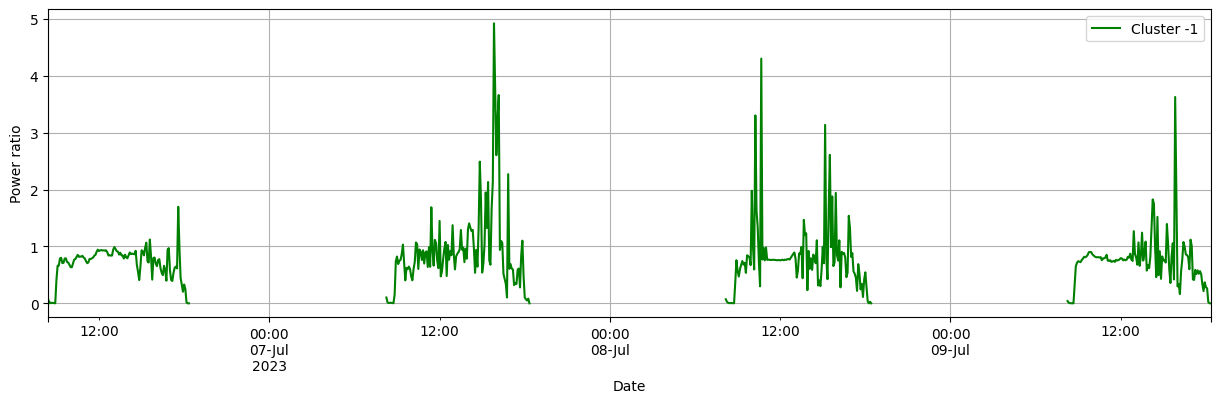

2023-07-09 00:00:00
2023-07-13 00:00:00


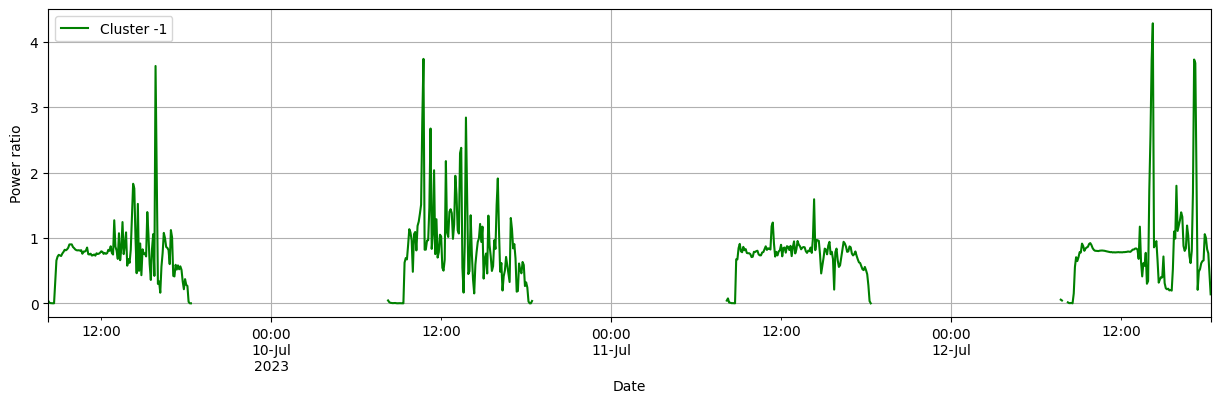

2023-07-12 00:00:00
2023-07-16 00:00:00


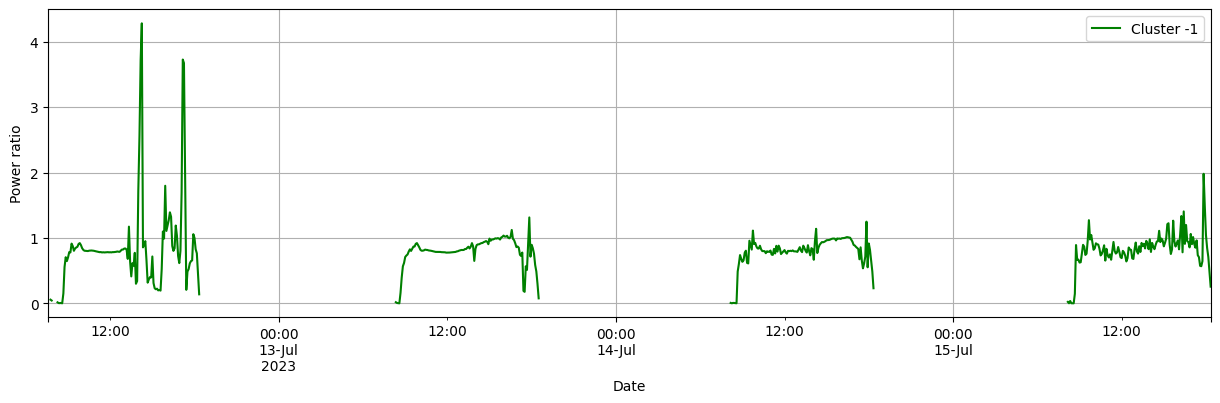

2023-07-15 00:00:00
2023-07-19 00:00:00


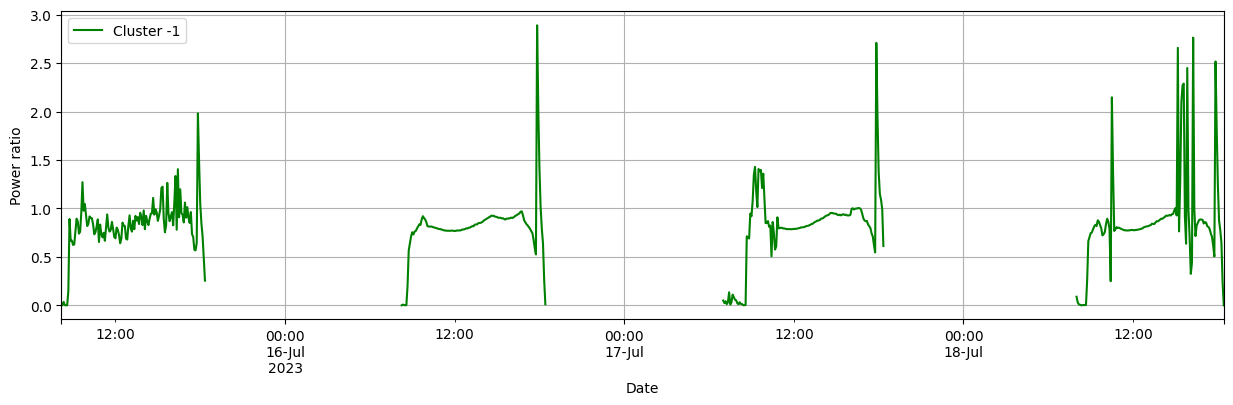

2023-07-18 00:00:00
2023-07-22 00:00:00


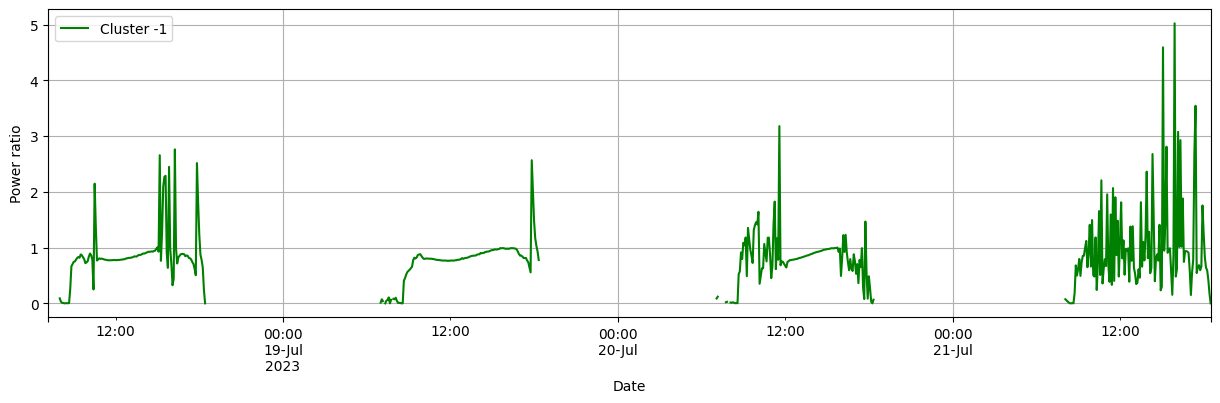

2023-07-21 00:00:00
2023-07-25 00:00:00


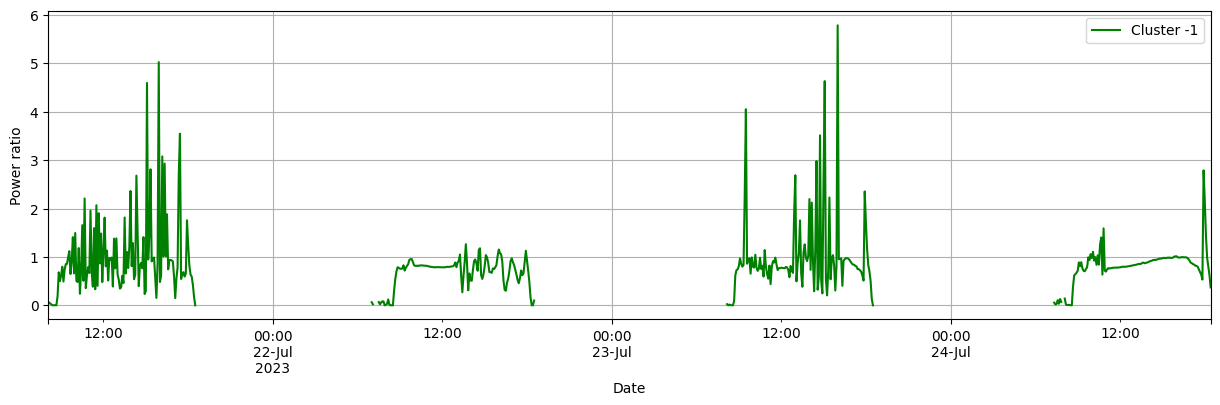

2023-07-24 00:00:00
2023-07-28 00:00:00


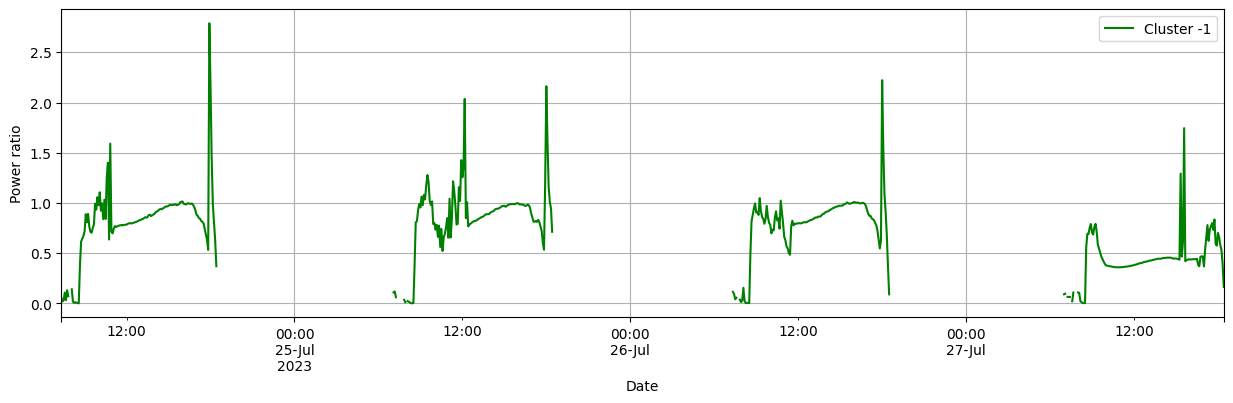

2023-07-27 00:00:00
2023-07-31 00:00:00


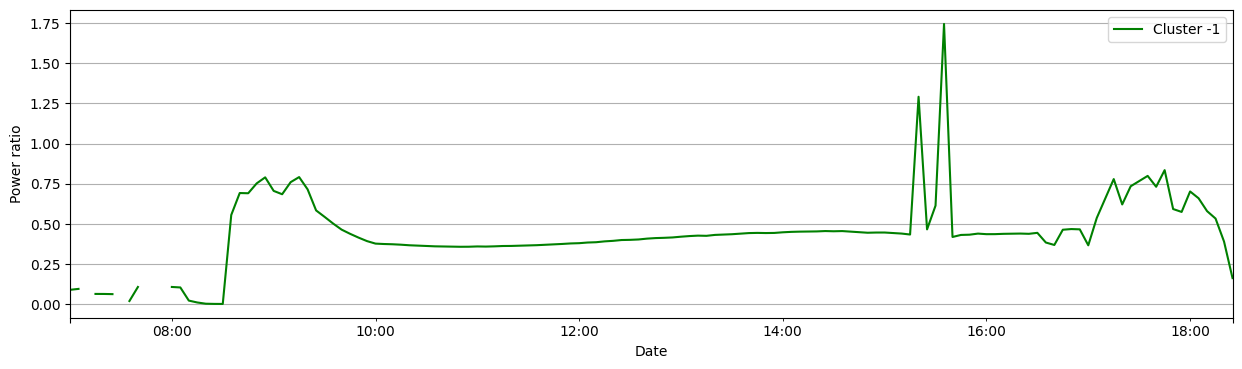

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-07-30 00:00:00
2023-08-03 00:00:00


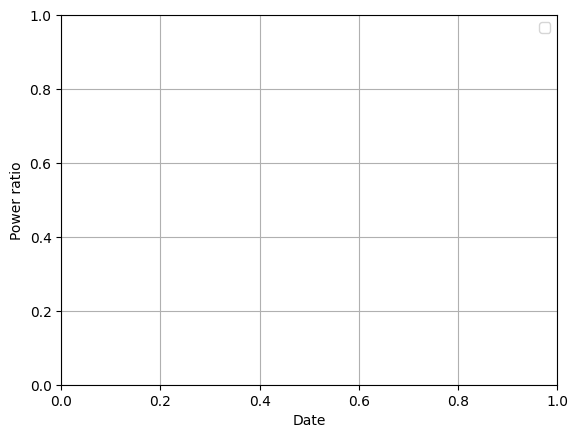

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-08-02 00:00:00
2023-08-06 00:00:00


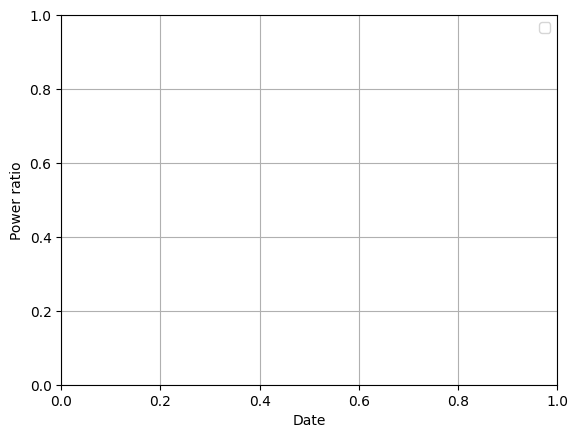

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-08-05 00:00:00
2023-08-09 00:00:00


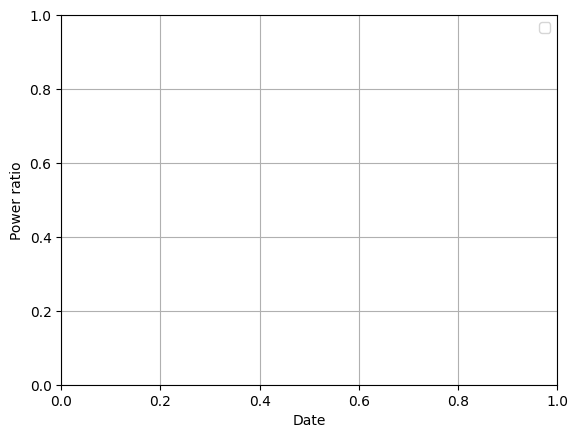

2023-08-08 00:00:00
2023-08-12 00:00:00


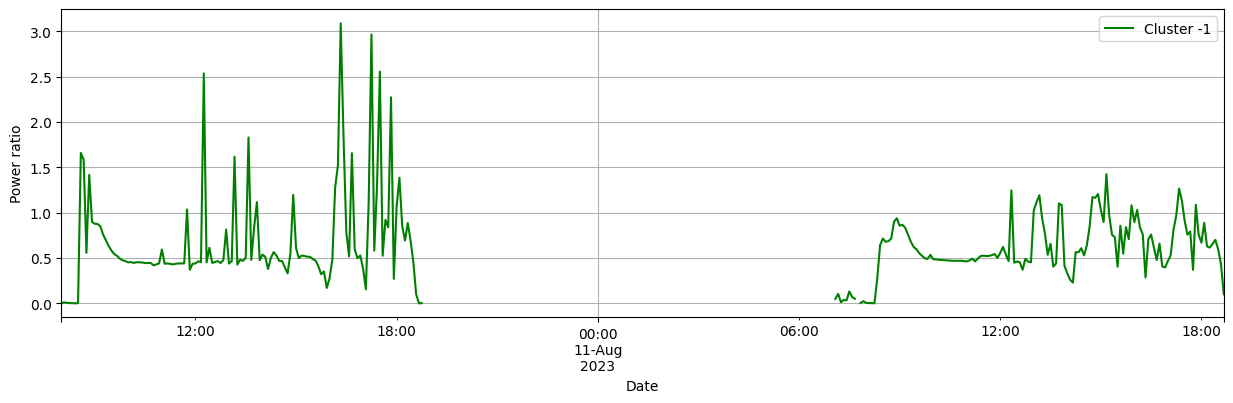

2023-08-11 00:00:00
2023-08-15 00:00:00


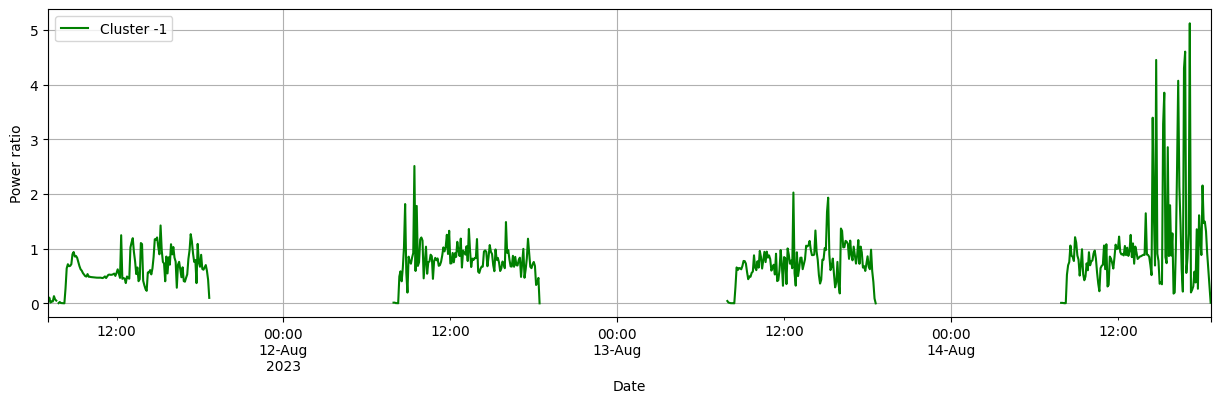

2023-08-14 00:00:00
2023-08-18 00:00:00


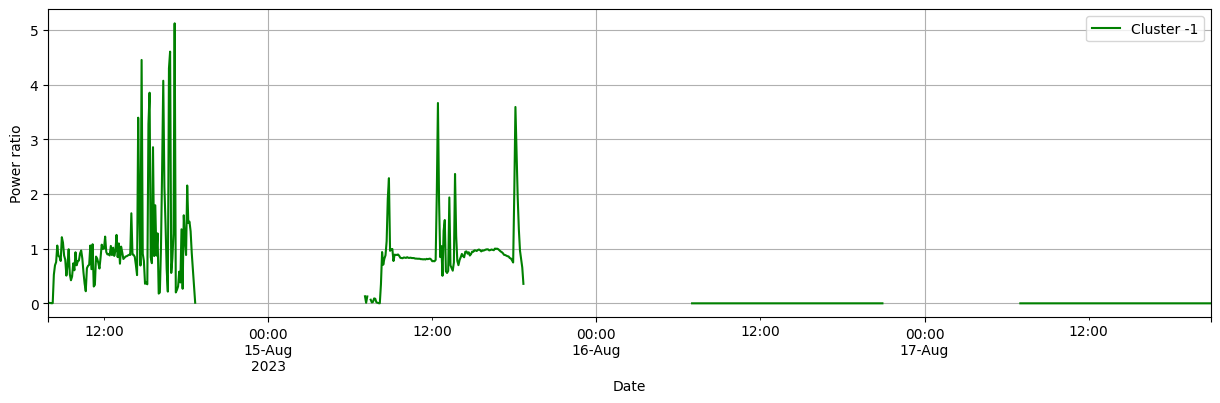

2023-08-17 00:00:00
2023-08-21 00:00:00


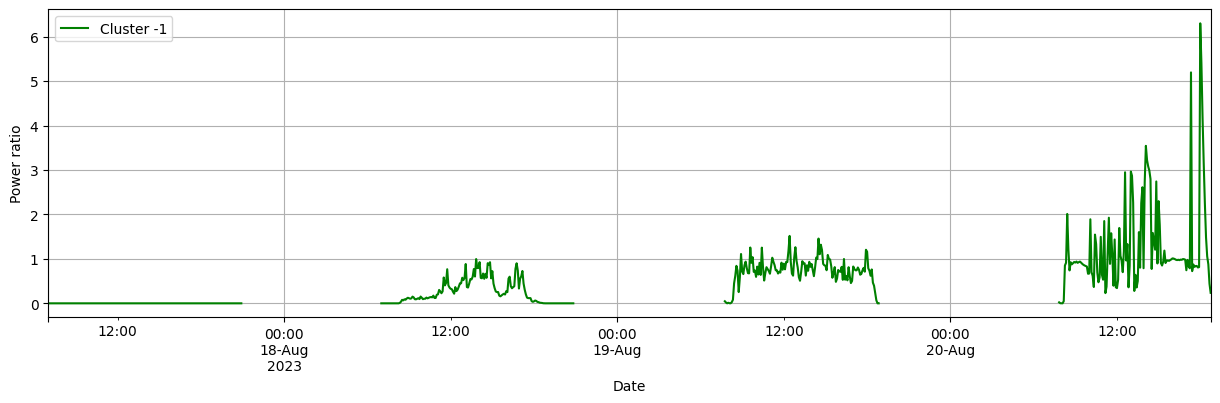

2023-08-20 00:00:00
2023-08-24 00:00:00


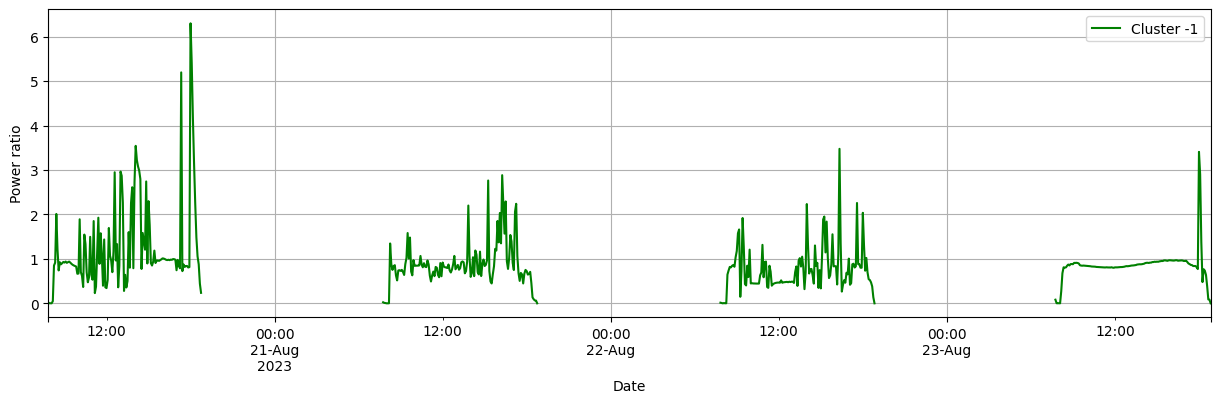

2023-08-23 00:00:00
2023-08-27 00:00:00


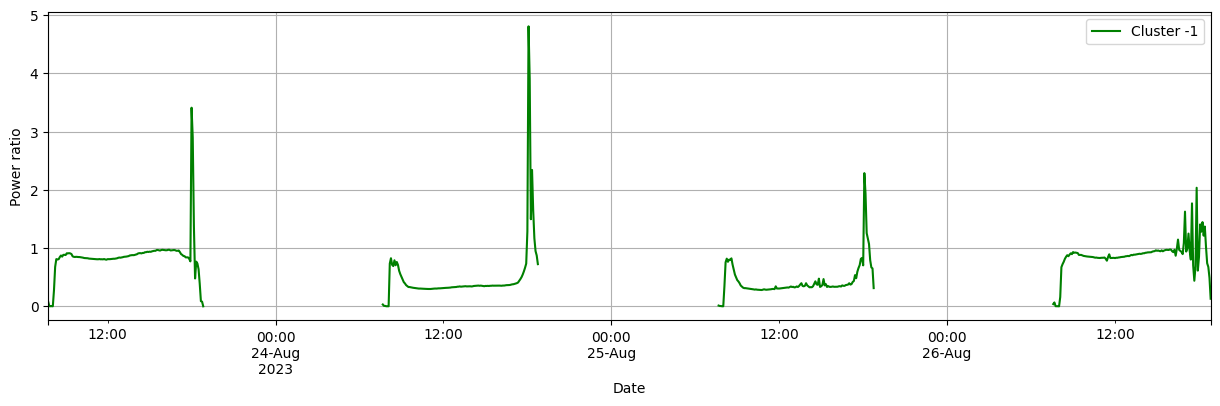

2023-08-26 00:00:00
2023-08-30 00:00:00


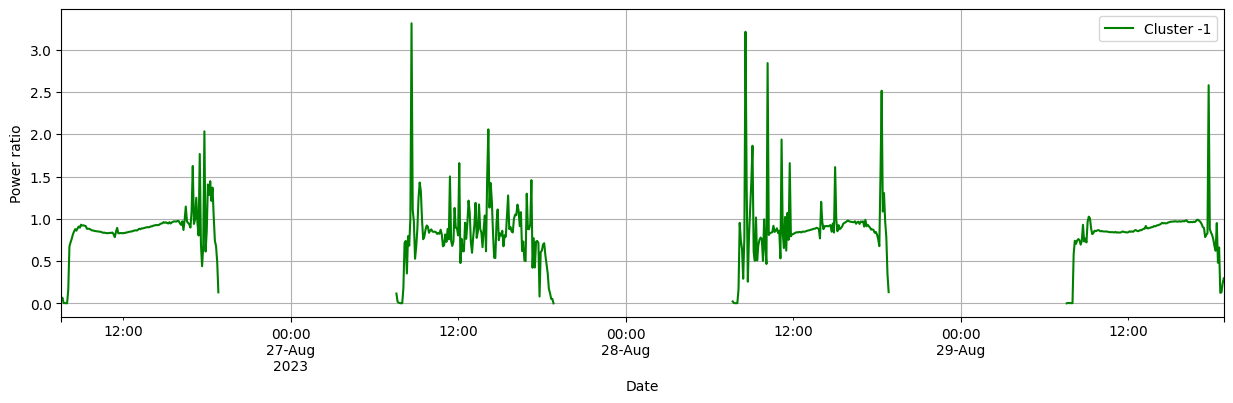

2023-08-29 00:00:00
2023-09-02 00:00:00


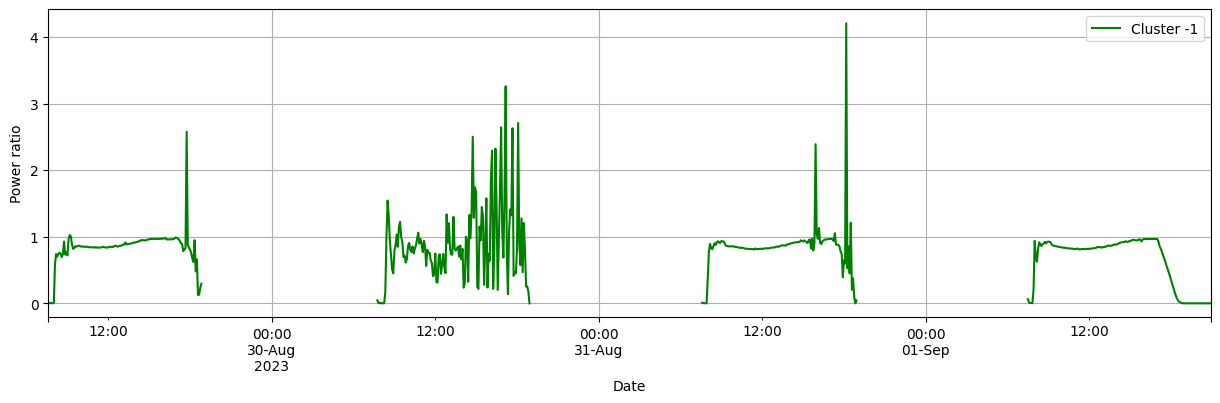

2023-09-01 00:00:00
2023-09-05 00:00:00


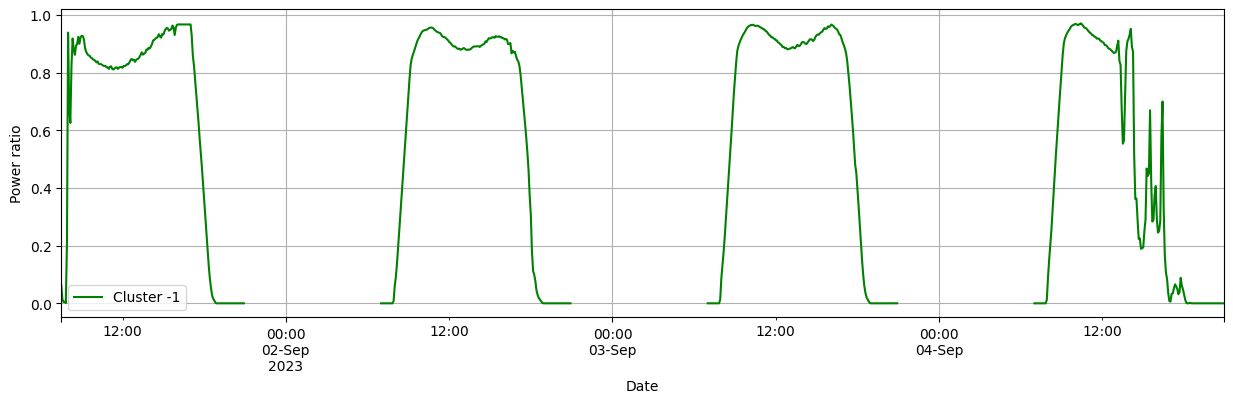

2023-09-04 00:00:00
2023-09-08 00:00:00


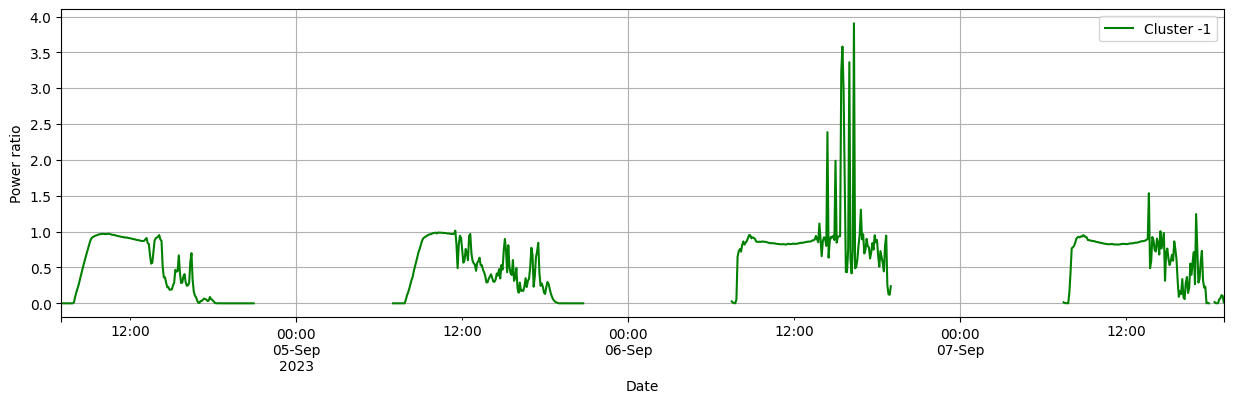

2023-09-07 00:00:00
2023-09-11 00:00:00


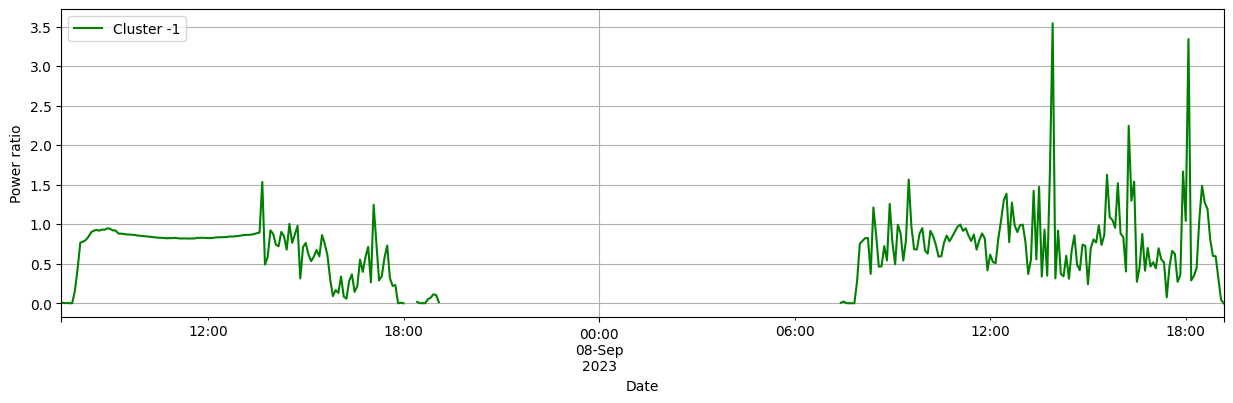

2023-09-10 00:00:00
2023-09-14 00:00:00


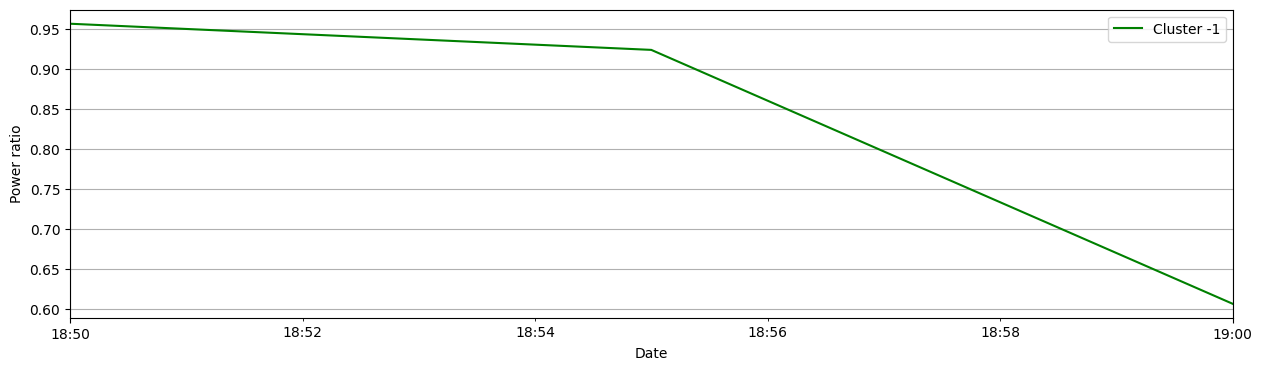

2023-09-13 00:00:00
2023-09-17 00:00:00


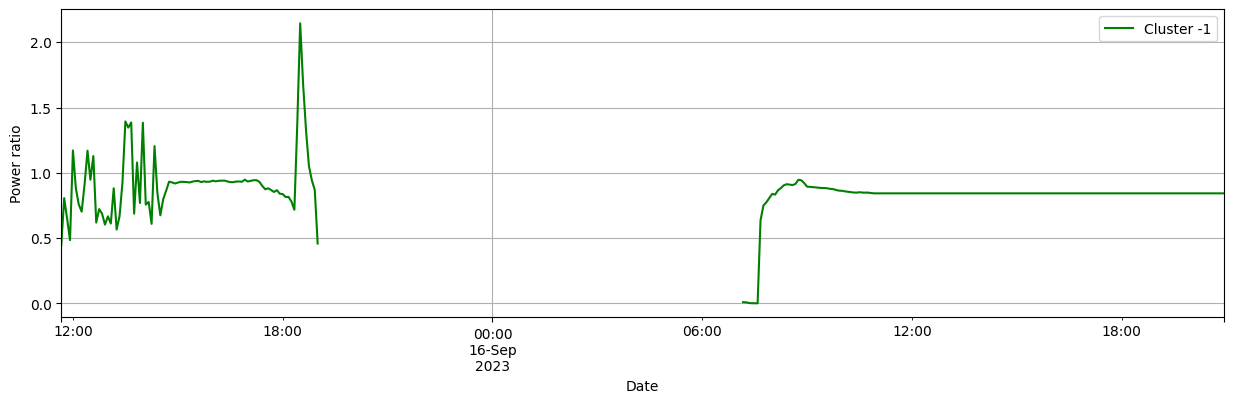

2023-09-16 00:00:00
2023-09-20 00:00:00


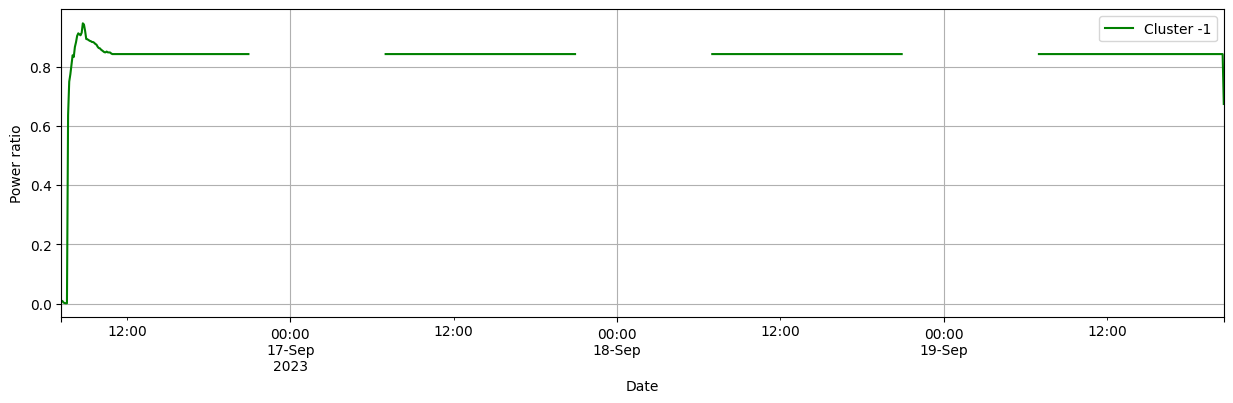

2023-09-19 00:00:00
2023-09-23 00:00:00


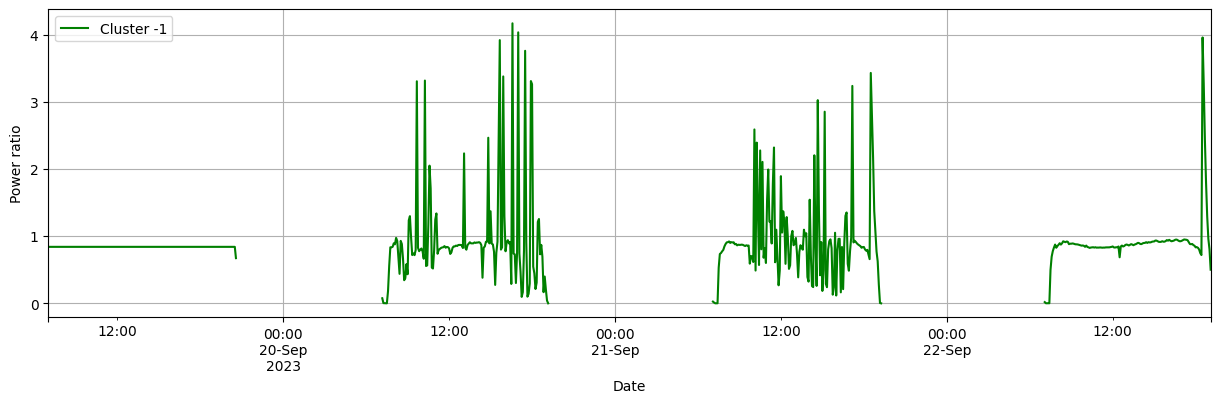

2023-09-22 00:00:00
2023-09-26 00:00:00


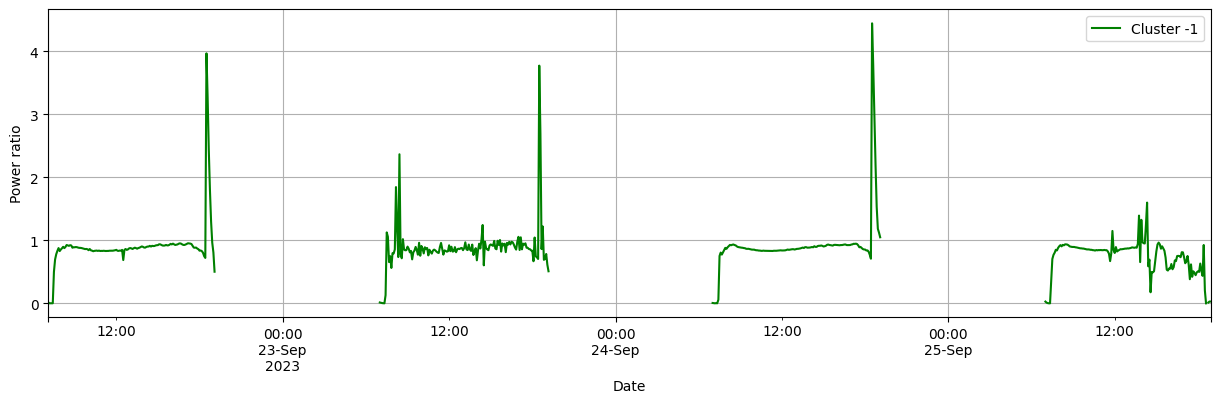

2023-09-25 00:00:00
2023-09-29 00:00:00


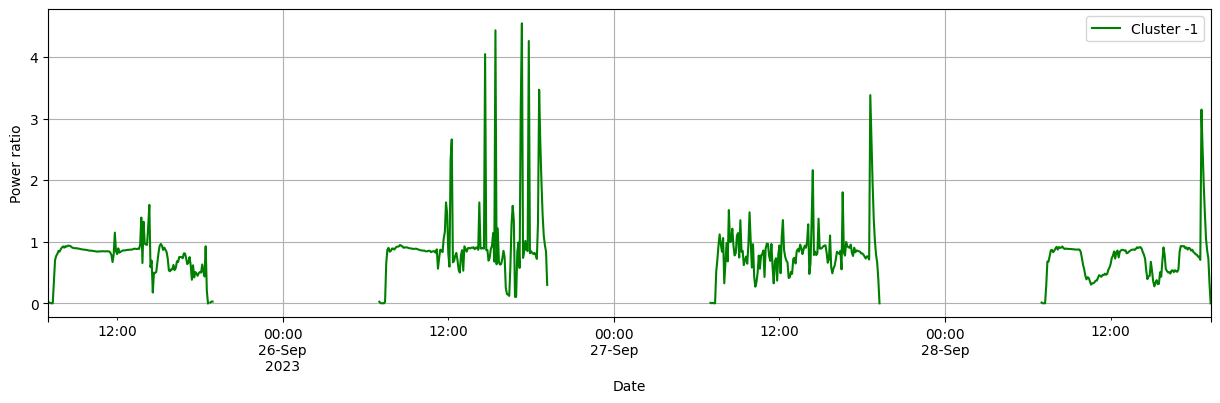

2023-09-28 00:00:00
2023-10-02 00:00:00


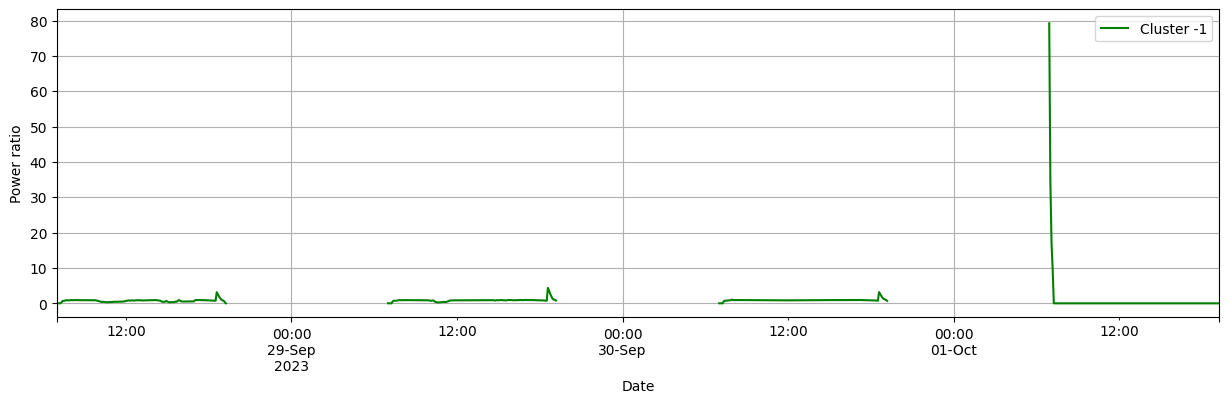

2023-10-01 00:00:00
2023-10-05 00:00:00


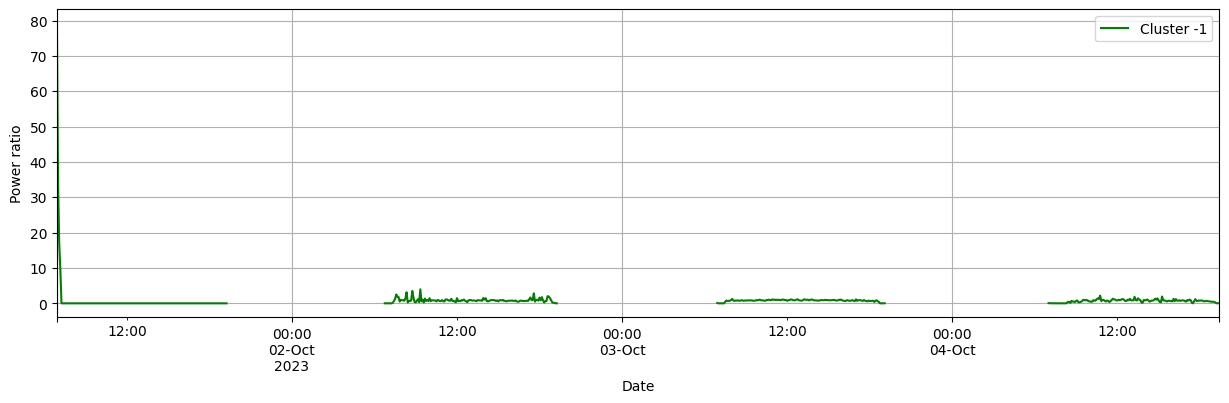

2023-10-04 00:00:00
2023-10-08 00:00:00


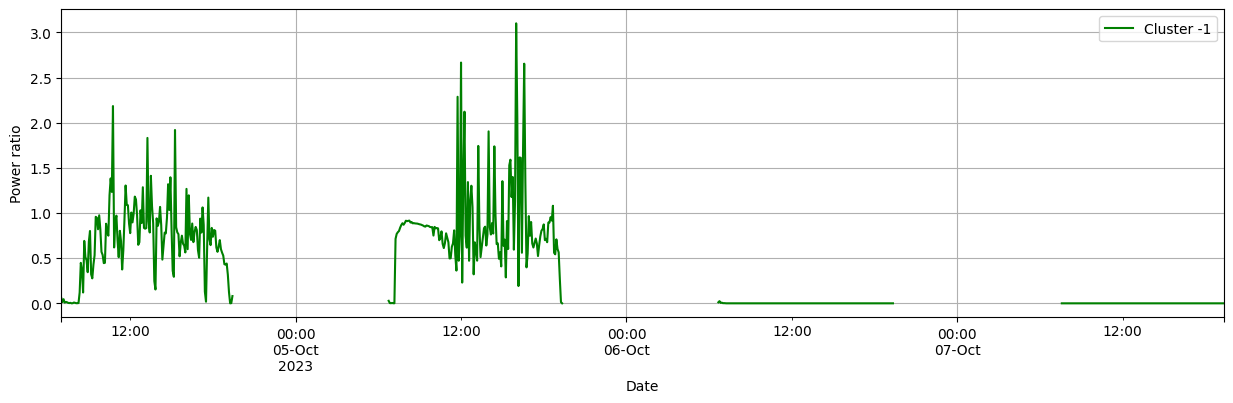

2023-10-07 00:00:00
2023-10-11 00:00:00


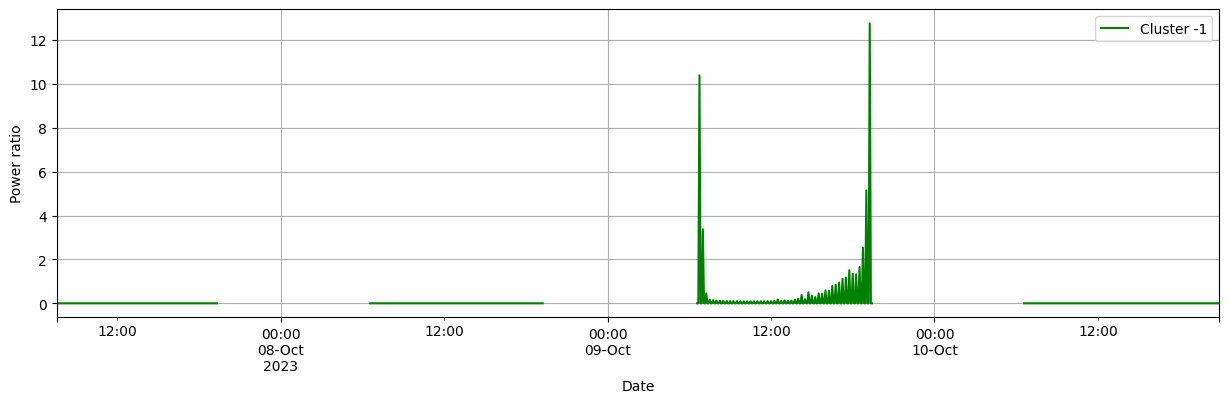

2023-10-10 00:00:00
2023-10-14 00:00:00


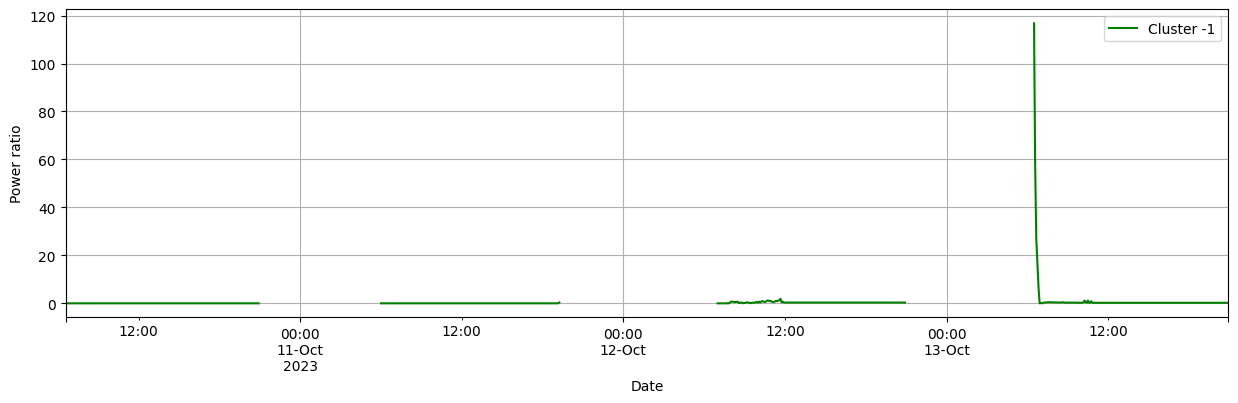

2023-10-13 00:00:00
2023-10-17 00:00:00


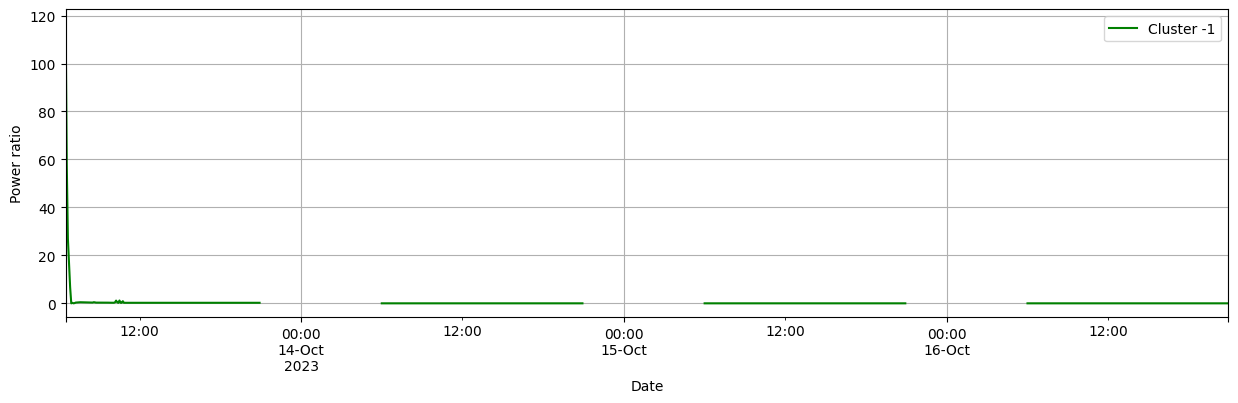

2023-10-16 00:00:00
2023-10-20 00:00:00


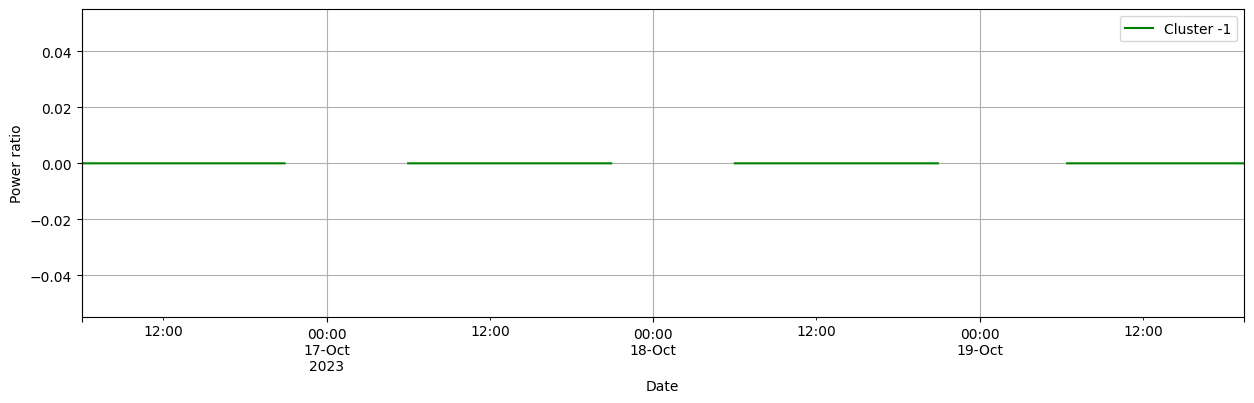

2023-10-19 00:00:00
2023-10-23 00:00:00


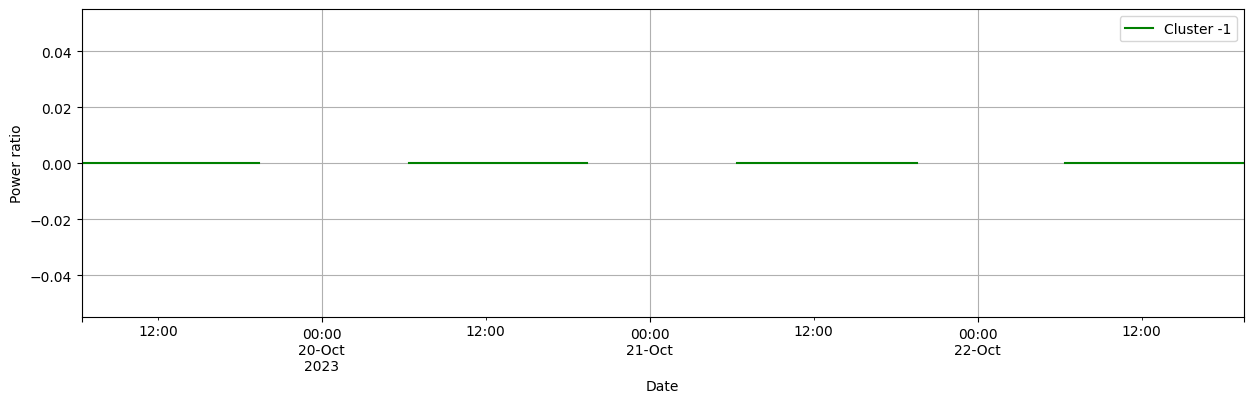

2023-10-22 00:00:00
2023-10-26 00:00:00


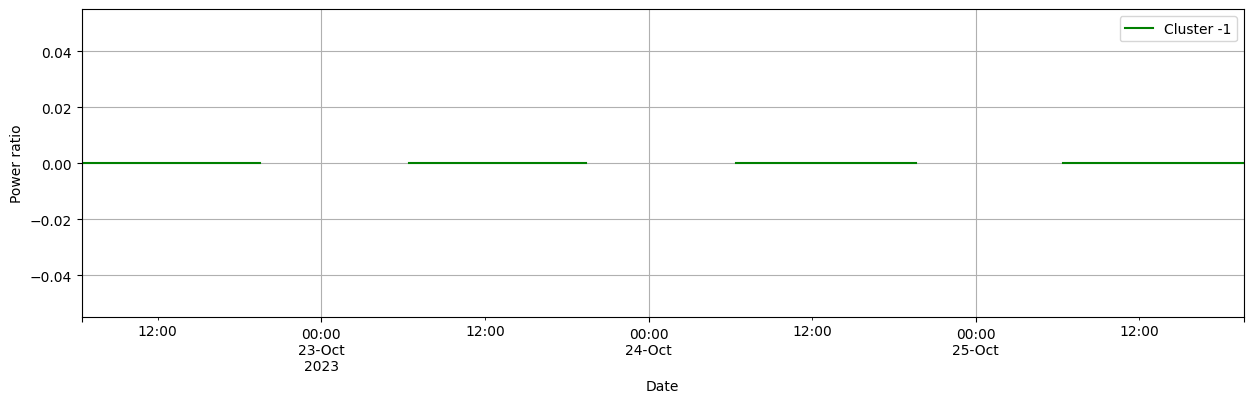

2023-10-25 00:00:00
2023-10-29 00:00:00


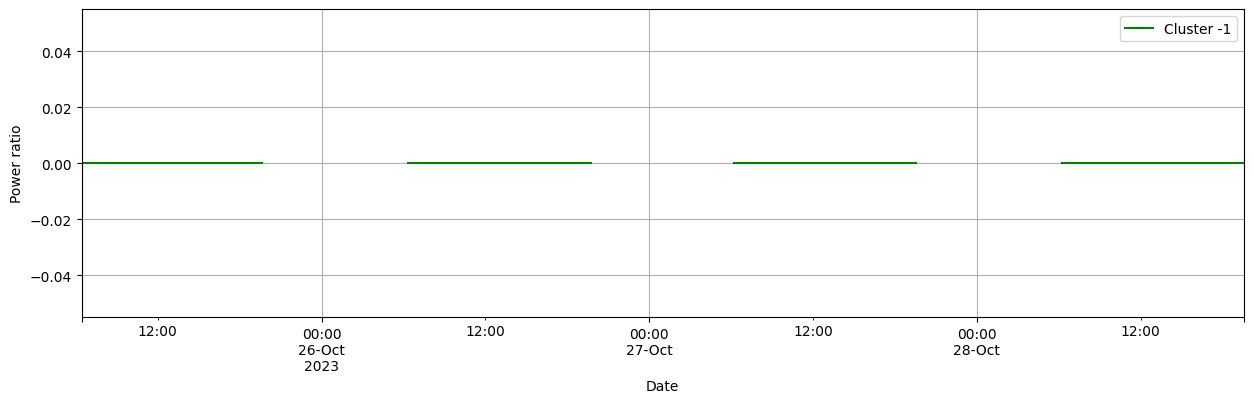

2023-10-28 00:00:00
2023-11-01 00:00:00


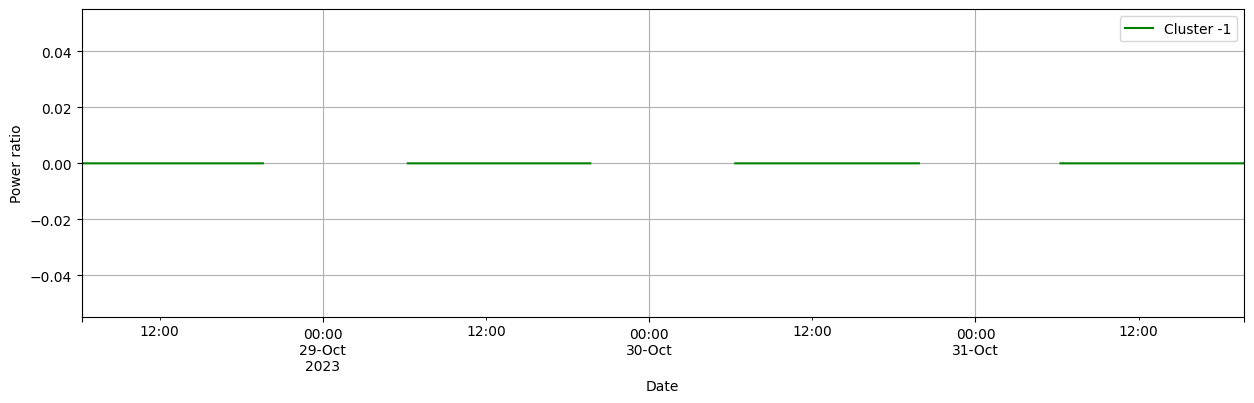

2023-10-31 00:00:00
2023-11-04 00:00:00


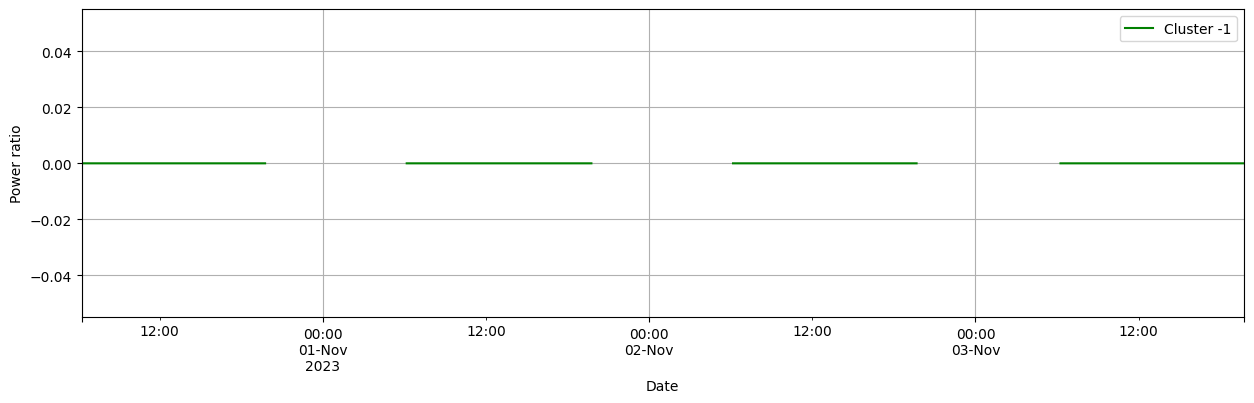

2023-11-03 00:00:00
2023-11-07 00:00:00


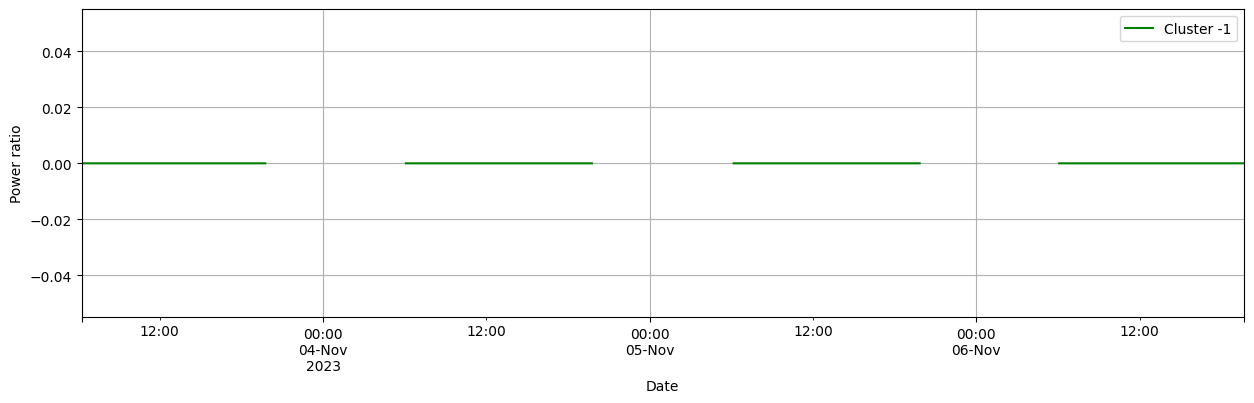

2023-11-06 00:00:00
2023-11-10 00:00:00


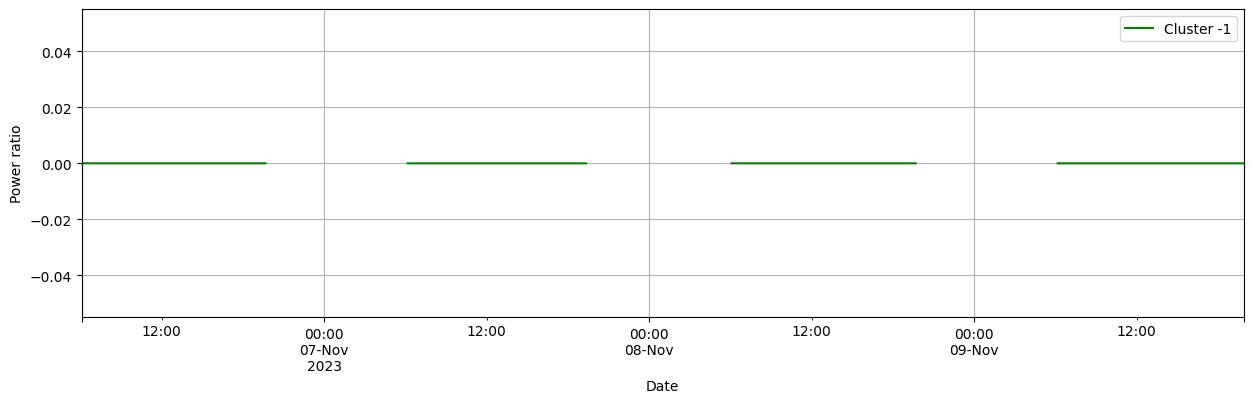

2023-11-09 00:00:00
2023-11-13 00:00:00


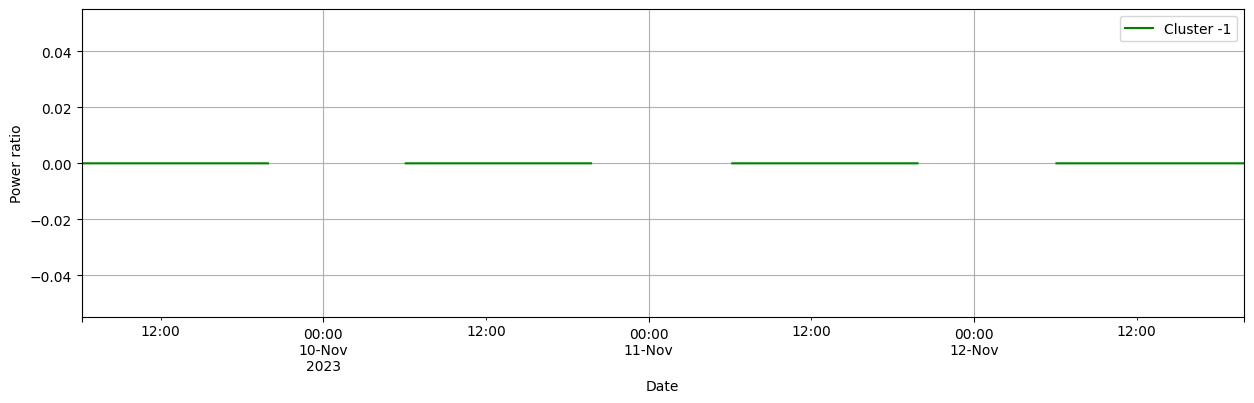

2023-11-12 00:00:00
2023-11-16 00:00:00


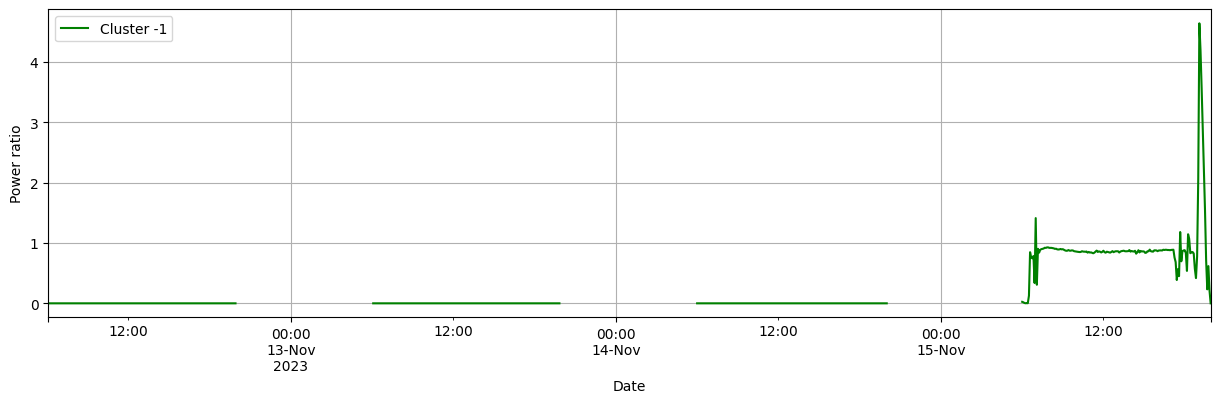

2023-11-15 00:00:00
2023-11-19 00:00:00


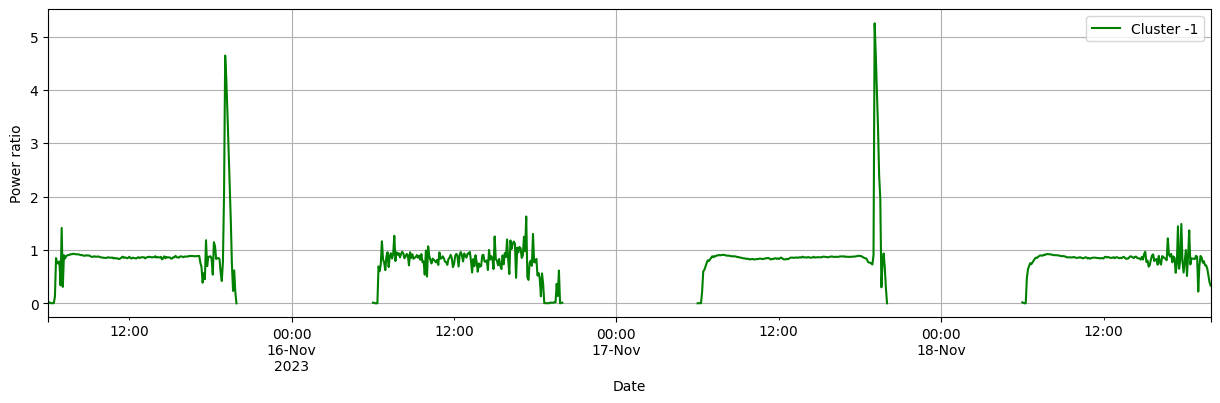

2023-11-18 00:00:00
2023-11-22 00:00:00


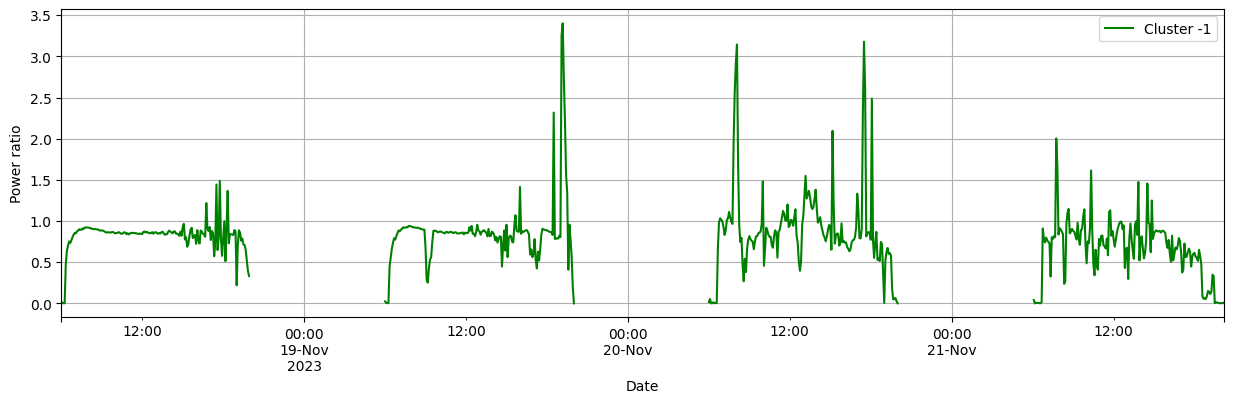

2023-11-21 00:00:00
2023-11-25 00:00:00


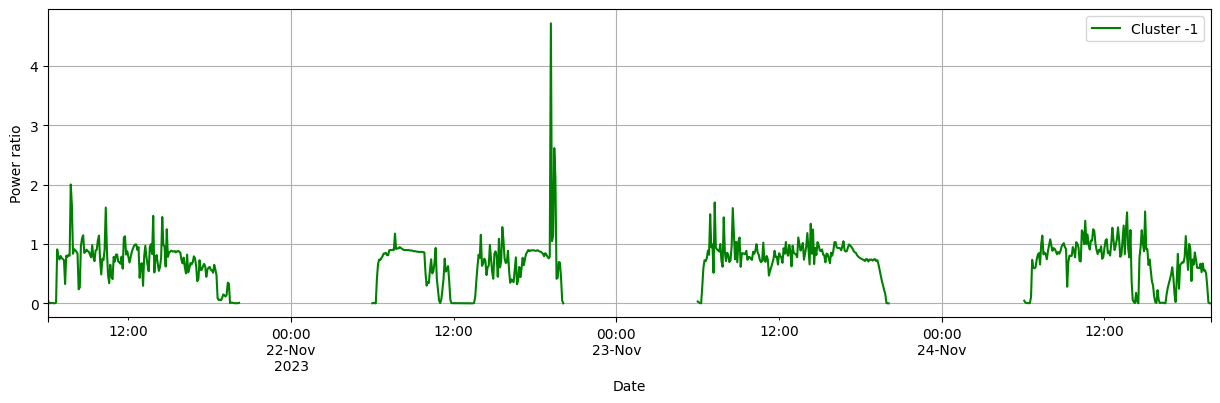

2023-11-24 00:00:00
2023-11-28 00:00:00


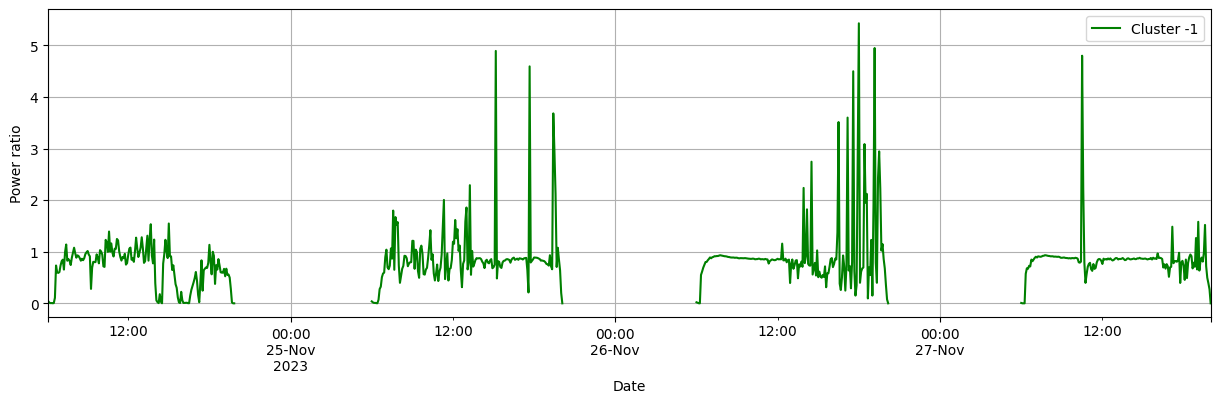

2023-11-27 00:00:00
2023-12-01 00:00:00


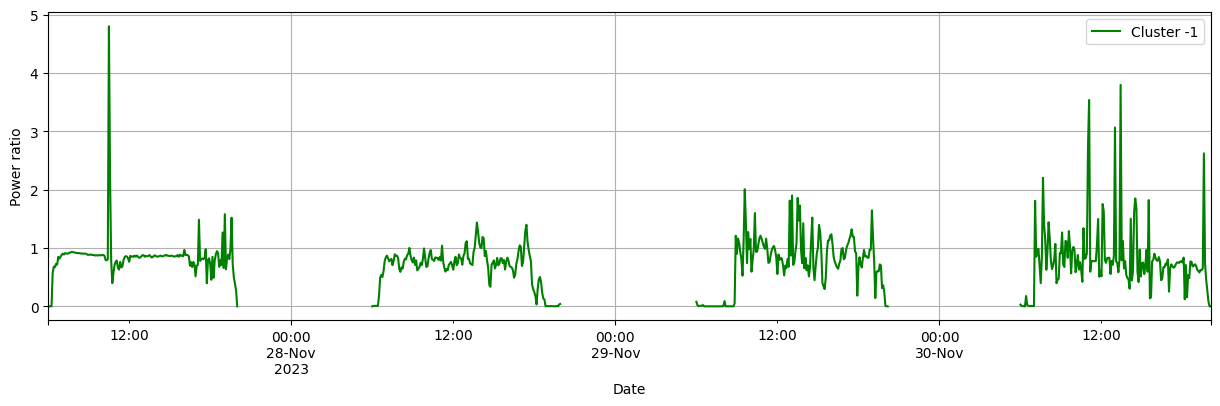

2023-11-30 00:00:00
2023-12-04 00:00:00


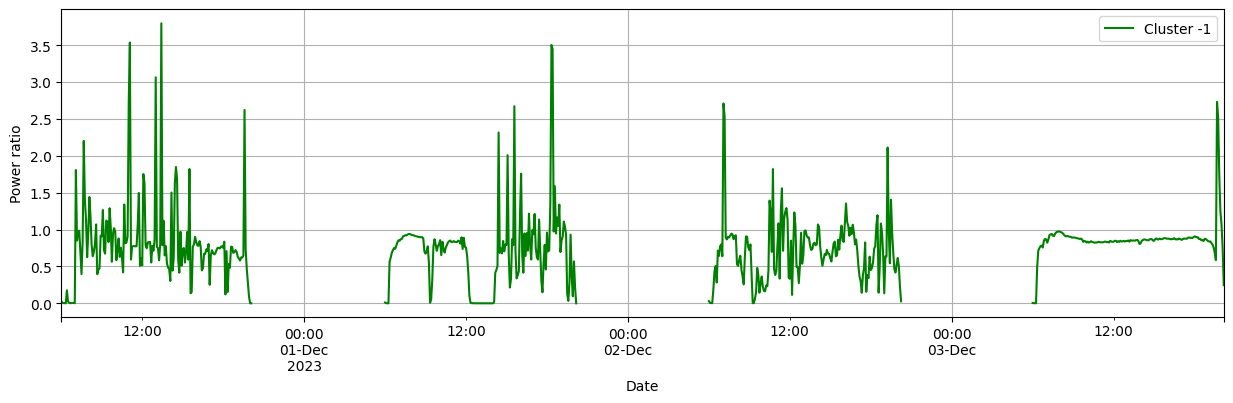

2023-12-03 00:00:00
2023-12-07 00:00:00


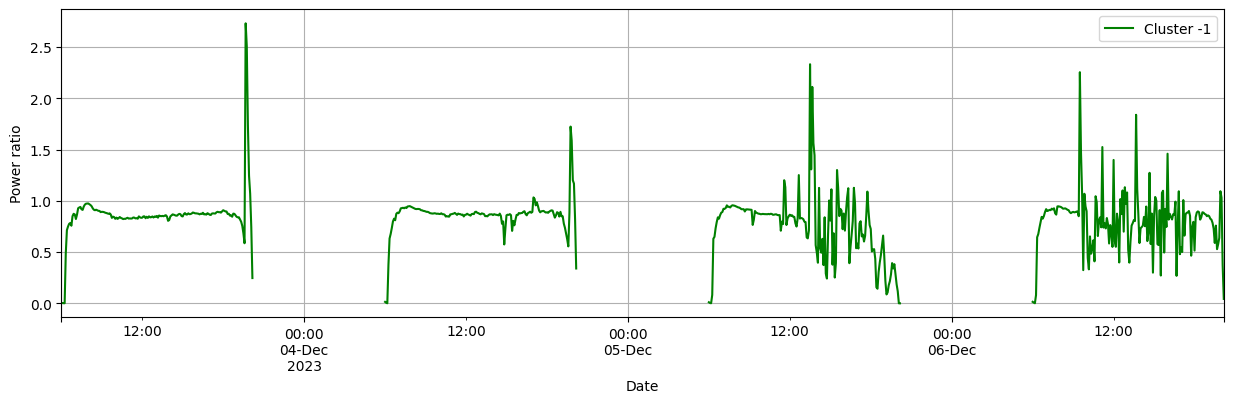

2023-12-06 00:00:00
2023-12-10 00:00:00


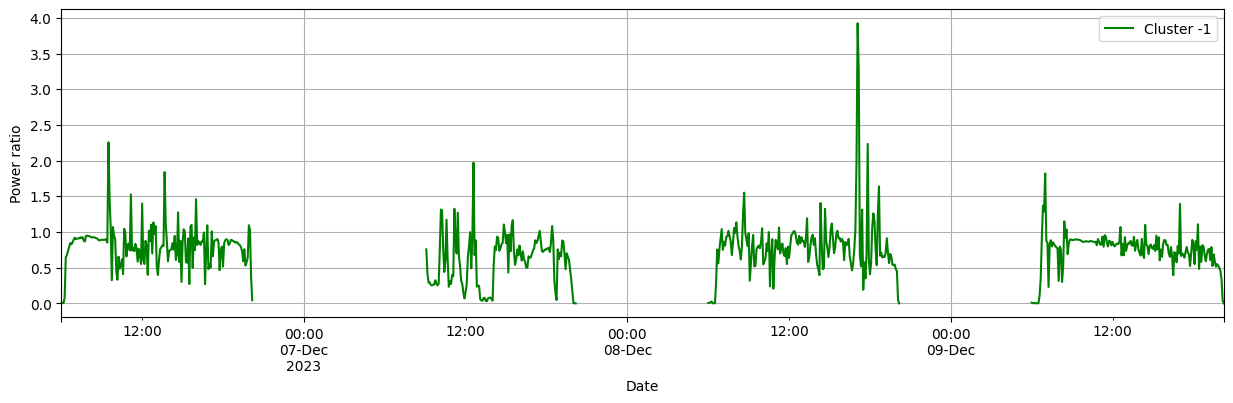

2023-12-09 00:00:00
2023-12-13 00:00:00


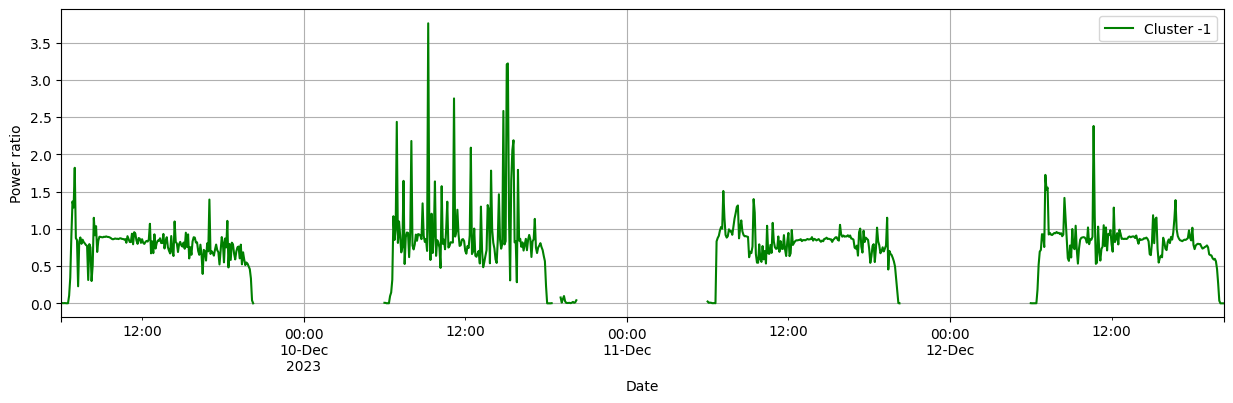

2023-12-12 00:00:00
2023-12-16 00:00:00


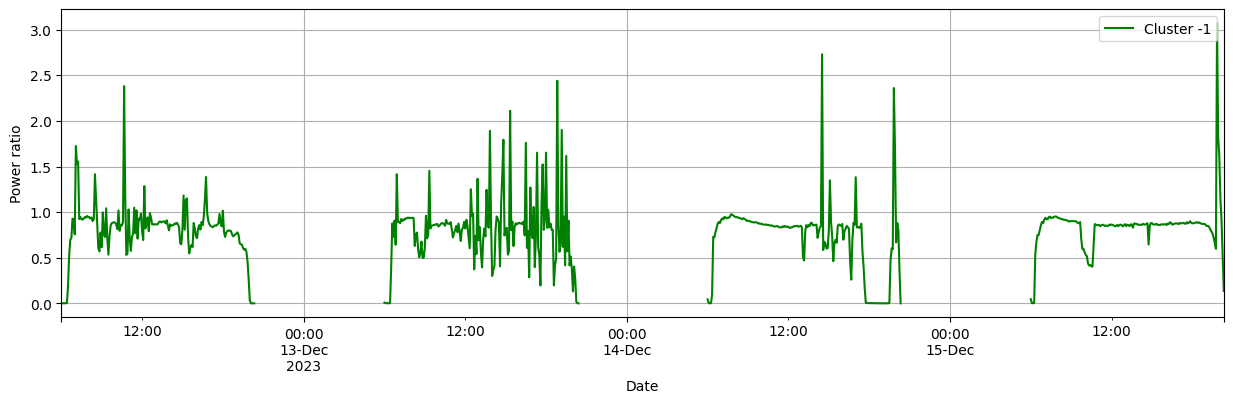

2023-12-15 00:00:00
2023-12-19 00:00:00


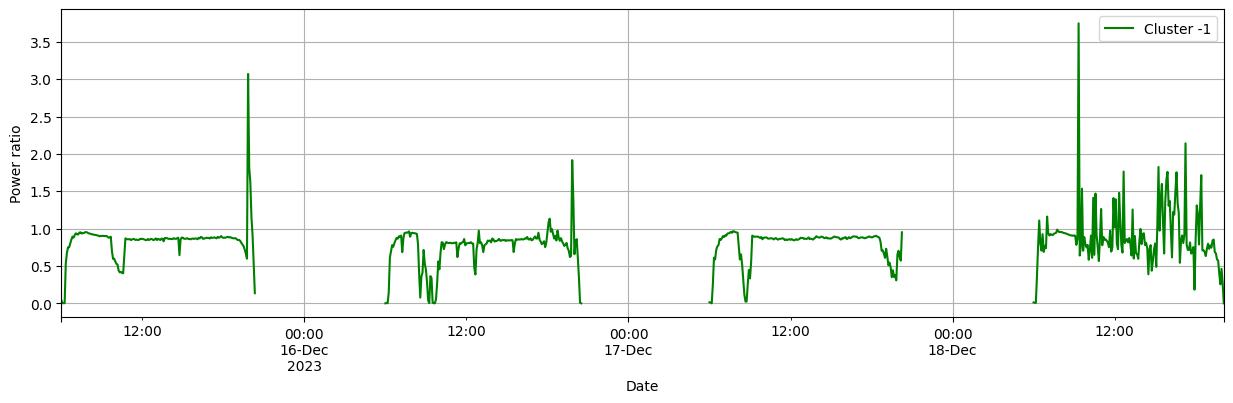

2023-12-18 00:00:00
2023-12-22 00:00:00


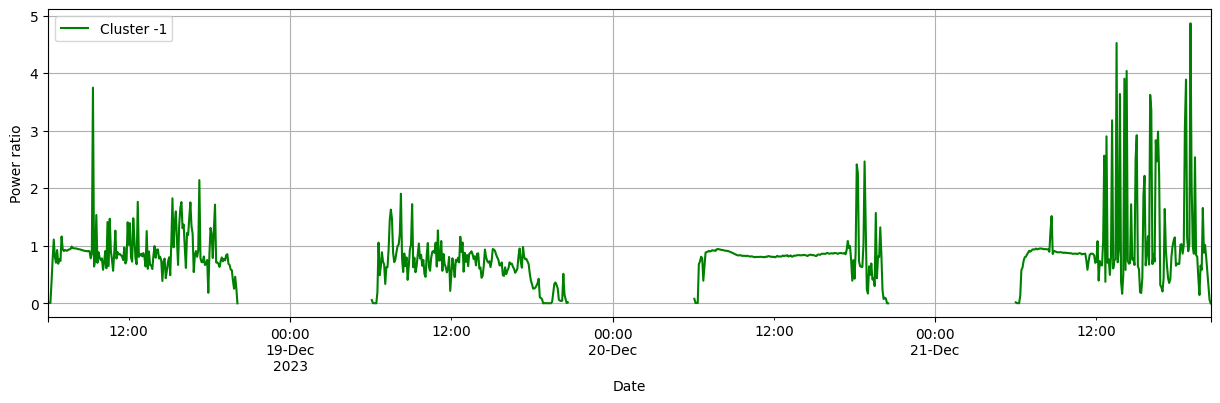

2023-12-21 00:00:00
2023-12-25 00:00:00


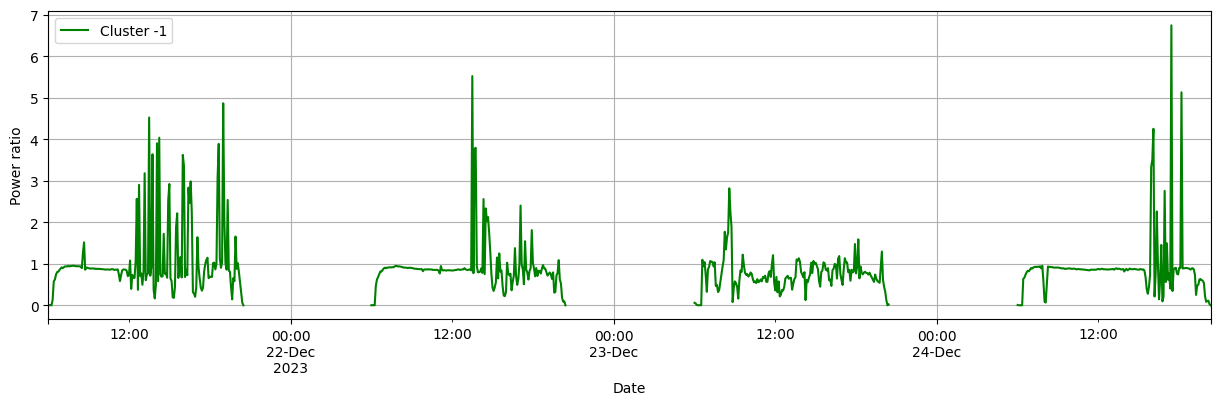

2023-12-24 00:00:00
2023-12-28 00:00:00


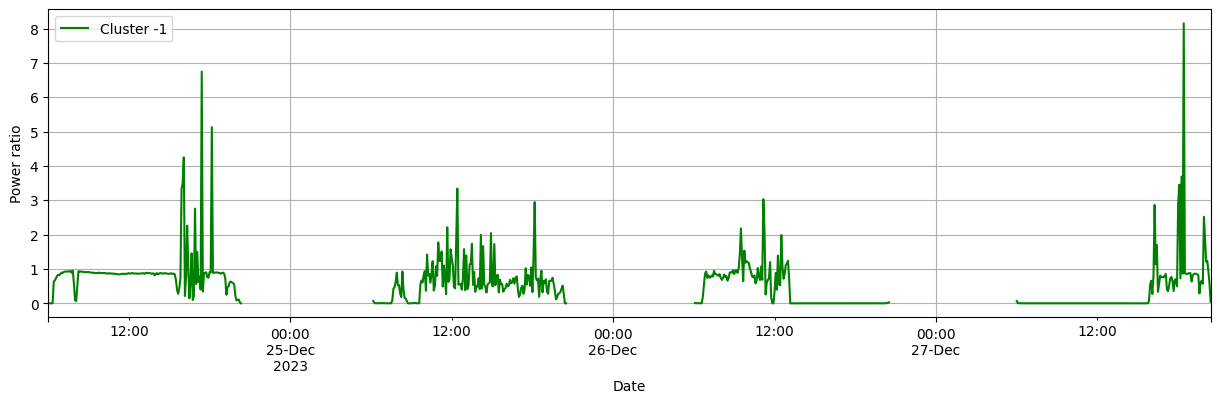

2023-12-27 00:00:00
2023-12-31 00:00:00


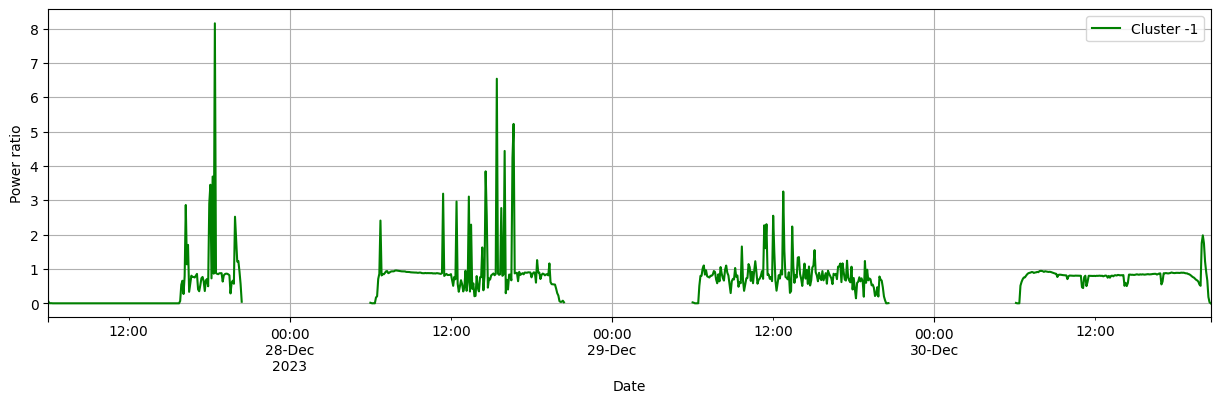

2023-12-30 00:00:00
2024-01-03 00:00:00


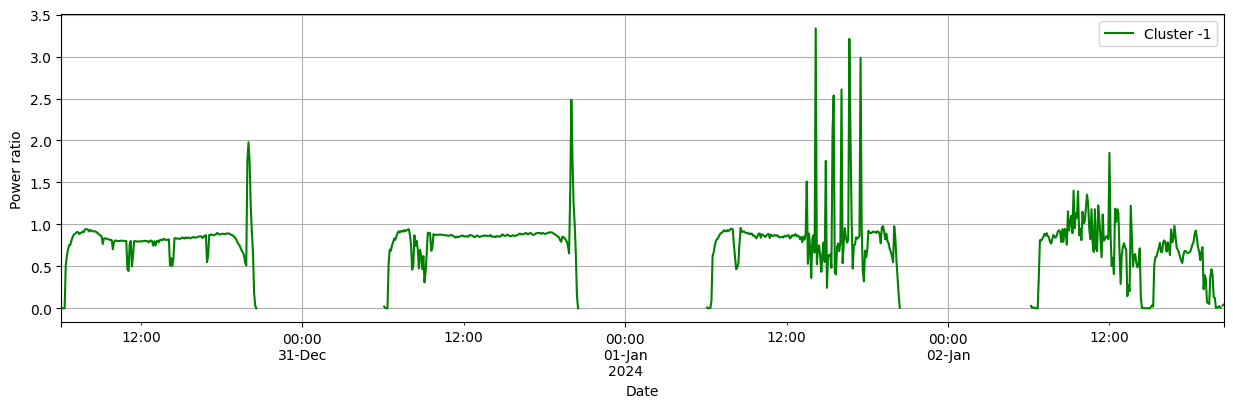

"\n# Loop through each date in the range\nfor n in range(int((end_date - start_date).days)):\n    date = start_date + timedelta(n+3)\n    print(start_date)\n    print(date)\n    for cluster in range(-1,5):\n        cluster_data = df_orginal.query('Clusters == @cluster')[start_date:date]\n        if not cluster_data.empty:\n            cluster_data['Power_ratio'].resample('5min').mean().plot(\n                figsize=(15, 4),\n                color=['Red', 'Black', 'Brown','Orange','Green'][cluster],\n                label=f'Cluster {cluster}'\n        )\n        \n    #plt.scatter(df_orginal[start_date:end_date].index[df_orginal[start_date:end_date]['anomaly'] == 1], df_orginal[start_date:end_date]['Power_error'][df_orginal[start_date:end_date]['anomaly'] == 1], color='black', label='Anomaly')\n    # Add labels, grid, and legend\n    plt.ylabel('Power ratio')\n    plt.xlabel('Date')\n    plt.grid(True)\n    plt.legend()\n    plt.show()\n\n    start_date = date\n        \n\ndf_orginal['

In [354]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Define the date range as datetime objects
start_date = datetime.strptime('2023-03-20', '%Y-%m-%d')
end_date = datetime.strptime('2024-01-01', '%Y-%m-%d')

current_date = start_date
# Continuously loop through the dates
while current_date <= end_date:
    # Calculate the end date for the current iteration (3 days ahead)
    date = current_date + timedelta(4)
    
    print(current_date)
    print(date)
    
    for cluster in range(-1, 5):
        cluster_data = df_orginal.query('Clusters == @cluster')[current_date:date]
        if not cluster_data.empty:
            cluster_data['Power_ratio'].resample('5min').mean().plot(
                figsize=(15, 4),
                color=['Red', 'Black', 'Brown', 'Orange', 'Green'][cluster],
                label=f'Cluster {cluster}'
            )
        
    # Add labels, grid, and legend
    plt.ylabel('Power ratio')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Increment the current date by 3 days
    current_date += timedelta(3)

'''
# Loop through each date in the range
for n in range(int((end_date - start_date).days)):
    date = start_date + timedelta(n+3)
    print(start_date)
    print(date)
    for cluster in range(-1,5):
        cluster_data = df_orginal.query('Clusters == @cluster')[start_date:date]
        if not cluster_data.empty:
            cluster_data['Power_ratio'].resample('5min').mean().plot(
                figsize=(15, 4),
                color=['Red', 'Black', 'Brown','Orange','Green'][cluster],
                label=f'Cluster {cluster}'
        )
        
    #plt.scatter(df_orginal[start_date:end_date].index[df_orginal[start_date:end_date]['anomaly'] == 1], df_orginal[start_date:end_date]['Power_error'][df_orginal[start_date:end_date]['anomaly'] == 1], color='black', label='Anomaly')
    # Add labels, grid, and legend
    plt.ylabel('Power ratio')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()
    plt.show()

    start_date = date
        

df_orginal['Power_ratio'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Power ratio')
plt.ylabel('Power ratio')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


# Check if clusters exist in the date range
for cluster in range(-1,5):
    cluster_data = df_orginal.query('Clusters == @cluster')[start_date:end_date]
    if not cluster_data.empty:
        cluster_data['Power_ratio'].resample('5min').mean().plot(
            figsize=(15, 4),
            color=['Red', 'Black', 'Brown','Orange','Green'][cluster],
            label=f'Cluster {cluster}'
        )
        
#plt.scatter(df_orginal[start_date:end_date].index[df_orginal[start_date:end_date]['anomaly'] == 1], df_orginal[start_date:end_date]['Power_error'][df_orginal[start_date:end_date]['anomaly'] == 1], color='black', label='Anomaly')
# Add labels, grid, and legend
plt.ylabel('Power ratio')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()


df_orginal['Power_deficit_ratio'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Power deficit ratio')
plt.ylabel('Power deficit ratio')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


# Check if clusters exist in the date range
for cluster in range(-1,5):
    cluster_data = df_orginal.query('Clusters == @cluster')[start_date:end_date]
    if not cluster_data.empty:
        cluster_data['Power_deficit_ratio'].resample('5min').mean().plot(
            figsize=(15, 4),
            color=['Red', 'Black', 'Brown','Orange','Green'][cluster],
            label=f'Cluster {cluster}'
        )
        
#plt.scatter(df_orginal[start_date:end_date].index[df_orginal[start_date:end_date]['anomaly'] == 1], df_orginal[start_date:end_date]['Power_error'][df_orginal[start_date:end_date]['anomaly'] == 1], color='black', label='Anomaly')
# Add labels, grid, and legend
plt.ylabel('Power deficit ratio')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()


df_orginal['Power'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Power')
plt.ylabel('Power')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


# Check if clusters exist in the date range
for cluster in range(-1,5):
    cluster_data = df_orginal.query('Clusters == @cluster')[start_date:end_date]
    if not cluster_data.empty:
        cluster_data['Power'].resample('5min').mean().plot(
            figsize=(15, 4),
            color=['Red', 'Black', 'Brown','Orange','Green'][cluster],
            label=f'Cluster {cluster}'
        )
        
#plt.scatter(df_orginal[start_date:end_date].index[df_orginal[start_date:end_date]['anomaly'] == 1], df_orginal[start_date:end_date]['Power_error'][df_orginal[start_date:end_date]['anomaly'] == 1], color='black', label='Anomaly')
# Add labels, grid, and legend
plt.ylabel('Power')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()


#df_orginal['reconstruction_error'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Red'],label='Reconstruction error')
#plt.scatter(df_orginal.index[df_orginal['anomaly'] == 1], df_orginal['Power_error'][df_orginal['anomaly'] == 1], color='black', label='Anomaly')
#plt.scatter(
#    df_orginal.loc[(df_orginal['anomaly'] == 1) & (df_orginal.index >= start_date) & (df_orginal.index <= end_date)].index,
#    df_orginal.loc[(df_orginal['anomaly'] == 1) & (df_orginal.index >= start_date) & (df_orginal.index <= end_date)]['Power_error'],
#    color='black',
#    label='Anomaly'
#)
#plt.ylabel('Power/ MW')
#plt.xlabel('Date')
#plt.legend()
#plt.grid(True)
#plt.show()

#anomalies = df_orginal[clusters == -1]
#print(anomalies)


#df_orginal['Power'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Residual Power')
#df_orginal[df_orginal['reconstruction_error']>threshold]['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Red'],label='Anomaly')
#plt.scatter(df_orginal_period.index[df_orginal_period['anomaly'] == 1], df_orginal_period['Power_error'][df_orginal_period['anomaly'] == 1], color='black', label='Anomaly')
#plt.ylabel('Power/ MW')
#plt.xlabel('Date')
#plt.legend()
#plt.grid(True)
#plt.show()
'''